In [649]:
import pandas as pd
import numpy as np
import os
import pysam
import pickle as pkl
from matplotlib import pyplot as plt
from matplotlib.patches import FancyArrow
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
from matplotlib import cm
from matplotlib.lines import Line2D
from matplotlib.colors import to_rgba
import seaborn as sns
from Bio import SeqIO
from Bio import SeqRecord
from Bio import Seq
from scipy import stats
from statsmodels.api import formula as smf
from progressbar import ProgressBar
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
import statsmodels.formula.api as smf
from roman import toRoman
import itertools
import intervaltree
import networkx as nx
from collections import Counter
import re
import random
import gzip
rc_sns = {'ytick_color':'k', 'xtick_color':'k', 'text_color':'k', 'font.sans-serif':'DejaVu Sans', 'figure.facecolor':(1,1,1,1)}
sns.set_style(style='ticks', rc=rc_sns)

In [748]:
#path for figures
fig_path = '/home/mathieu/mhenault_landrylab/Publications/lrma/draft/fig/'
tables_path = '/home/mathieu/mhenault_landrylab/Publications/lrma/draft/tables/'

# Import metadata and define general variables

In [3]:
#import tables of strain identities and cross parents
nano_strains = pd.read_csv('/mnt/HDD3/lrma/script/nano_strains.csv', index_col=0)
Cross_parents = pd.read_csv('/mnt/HDD3/lrma/private_variants/cross_parents.txt', sep=';', header=None, index_col=0).squeeze()

In [4]:
cross_alias = {'VL3':'CC1',
              'VL4':'CC2',
              'VL5':'CC3',
              'VL1':'BB1',
              'VL2':'BB2',
              'L1':'BC1',
              'L2':'BC2',
              'M1':'BA1',
              'M2':'BA2',
              'H1':'BSc1',
              'H2':'BSc2'}
nano_strains['cross'] = nano_strains['cross'].replace(cross_alias)
cross_order = {j:i for i,j in enumerate(['CC1', 'CC2', 'CC3', 'BB1', 'BB2', 'BC1', 'BC2', 'BA1', 'BA2', 'BSc1', 'BSc2'])}
cross_color = nano_strains.groupby('cross')['cross_color'].apply(lambda x: x.iloc[0]).to_dict()

In [5]:
#import tables of strain identities and cross parents
nano_strains = pd.read_csv('/mnt/HDD3/lrma/script/nano_strains.csv', index_col=0)
nano_strains['cross'] = nano_strains['cross'].replace(cross_alias)
cross_parents = pd.read_csv('/mnt/HDD3/lrma/script/cross_parents.csv', sep=',', index_col=0)
cross_color = nano_strains.groupby('cross')['cross_color'].apply(lambda x: x.iloc[0]).to_dict()

parents_background = cross_parents.value_counts(['strain', 'group', 'mat', 'ho', 'ade2']).rename('count').reset_index().set_index('strain')

In [6]:
# dict of parental strains with new cross IDs
for (cross, p) in Cross_parents.items():
    Cross_parents[cross_alias[cross]] = p
Parents_order = dict(zip(['LL2011_004', 'LL2011_009', 'MSH-587-1', 'LL2011_012', 'LL2011_001',
                          'MSH-604', 'UWOPS-91-202', 'LL2012_028', 'LL2012_021',
                          'YPS644', 'YPS744', 'LL2013_040', 'LL2013_054'], range(13)))

parents_group = {'MSH-604':'SpB',
                   'UWOPS-91-202':'SpB',
                   'LL2012_021':'SpB',
                   'LL2012_028':'SpB',
                   'LL2011_004':'SpC',
                   'LL2011_009':'SpC',
                   'MSH-587-1':'SpC',
                   'LL2011_012':'SpC',
                   'LL2011_001':'SpC',
                   'YPS644':'SpA',
                   'YPS744':'SpA',
                   'LL2013_040':'Sc',
                   'LL2013_054':'Sc'}

parents_color = {'MSH-604':'red',
                   'UWOPS-91-202':'red',
                   'LL2012_021':'darkred',
                   'LL2012_028':'darkred',
                   'LL2011_004':'dodgerblue',
                   'LL2011_009':'dodgerblue',
                   'MSH-587-1':'midnightblue',
                   'LL2011_012':'midnightblue',
                   'LL2011_001':'midnightblue',
                   'YPS644':'limegreen',
                   'YPS744':'limegreen',
                   'LL2013_040':'dimgrey',
                   'LL2013_054':'dimgrey'}

mat_alias = {'a': r'$a$', 'alpha':r'$\alpha$'}
group_alias = {'SpA':r'$SpA$', 'SpB':r'$SpB$', 'SpC':r'$SpC$', 'Scer':r'$S.c.$'}

In [7]:
# list parents
Parents = list(nano_strains.loc[nano_strains['cross']=='P', 'strain'].values)

In [8]:
ty_order = ['Ty1p', 'Ty3p', 'Tsu4', 'TY1', 'TY2', 'TY3', 'TY4']

ty_colors = {'Ty1p':'blue',
             'Ty3p':'forestgreen',
             'Tsu4':'red',
             'Ty5p':'gold',
             'TY1':'dodgerblue',
             'TY2':'cyan',
             'TY3':'limegreen',
             'TY4':'lightcoral',
             'TY5':'yellow'}

ty_alias = {'Ty1p':r'Ty1 Sp',
             'Ty3p':'Ty3 Sp',
             'Tsu4':'Tsu4',
             'Ty5p':'Ty5 Sp',
             'TY1':'Ty1 Sc',
             'TY2':'Ty2',
             'TY3':'Ty3 Sc',
             'TY4':'Ty4',
             'TY5':'Ty5 Sc'}

In [9]:
[(ty, np.array(to_rgba(c))*255) for (ty,c) in ty_colors.items()]

[('Ty1p', array([  0.,   0., 255., 255.])),
 ('Ty3p', array([ 34., 139.,  34., 255.])),
 ('Tsu4', array([255.,   0.,   0., 255.])),
 ('Ty5p', array([255., 215.,   0., 255.])),
 ('TY1', array([ 30., 144., 255., 255.])),
 ('TY2', array([  0., 255., 255., 255.])),
 ('TY3', array([ 50., 205.,  50., 255.])),
 ('TY4', array([240., 128., 128., 255.])),
 ('TY5', array([255., 255.,   0., 255.]))]

In [10]:
# color dictionary for annot types
at_color = {'fl':'red', 'solo':'blue', 'tr':'green'}

In [11]:
ns_subg = pd.read_csv('/mnt/HDD3/lrma/script/ns_subg.csv', index_col=0)
ns_subg['cross'] = ns_subg['cross'].replace(cross_alias)

# General functions

In [12]:
def plot_pval_symbol(p):
    if p<=0.001:
        pdisplay = '***'
    elif p<=0.01:
        pdisplay = '**'
    elif p<=0.05:
        pdisplay = '*'
    else:
        pdisplay = None
    return pdisplay

def plot_pval_text(p):
    if p<=0.001:
        pdisplay = f'{p:.1e}'
    elif p<=0.01:
        pdisplay = f'{p:.4f}'
    elif p<=0.1:
        pdisplay = f'{p:.3f}'
    elif p<=1:
        pdisplay = f'{p:.2f}'
    elif p>1:
        pdisplay = f'{p:.1f}'
    else:
        pdisplay = None
    return pdisplay

# Import chromosomes and contig offsets

In [13]:
tig_off = {}
for r in ns_subg['subg'].unique():
    path = f'/home/mathieu/paradoxus_nanopore/MA_parents/assemblies/{r}.chromosomes.rdna.fasta'
    
    df = pd.concat([pd.Series([seq.id, len(seq.seq)]) for seq in SeqIO.parse(path, 'fasta')], axis=1).T
    df.index = df[0].values
    df[2] = np.concatenate([np.array([0]), np.cumsum(df[1].values)[:-1]])
    df[3] = df[1] + df[2]
    df['color'] = np.tile([0,1], 10)[:df.shape[0]]
    df['rank'] = range(df.shape[0])
    
    tig_off[r] = df

In [14]:
# tract definition done in a separate script
# MA lines subgenomes + parents

Tracts = []

# MA lines subgenomes
for s in ns_subg.loc[ns_subg['identity_filter']==True].index:
    tracts = pd.read_csv(f'/mnt/HDD3/lrma/depth_tracts/{s}.tracts.csv', index_col=0)
    subg = s.split('.')[1]
    tracts['subg'] = subg
    
    for chrom, df in tracts.groupby('chrom'):
        tracts.loc[df.index, 'Start'] = df['start'] + tig_off[subg].loc[chrom, 2]
        tracts.loc[df.index, 'End'] = df['end'] + tig_off[subg].loc[chrom, 2]
    
    Tracts.append(tracts)

# parents
for s in nano_strains.loc[nano_strains['cross']=='P'].index:
    tracts = pd.read_csv(f'/mnt/HDD3/lrma/depth_tracts/{s}.tracts.csv', index_col=0)
    subg = s
    tracts['subg'] = subg
    
    for chrom, df in tracts.groupby('chrom'):
        tracts.loc[df.index, 'Start'] = df['start'] + tig_off[subg].loc[chrom, 2]
        tracts.loc[df.index, 'End'] = df['end'] + tig_off[subg].loc[chrom, 2]
        
    Tracts.append(tracts)
        
Tracts = pd.concat(Tracts).reset_index(drop=True)

# Import genome annotations

In [15]:
GFF = {}
nano_strains_annot = pd.read_csv('/mnt/HDD1/paradoxus_nanopore/MA_parents/annotation/nanopore_assemblies.csv', index_col=0)
# create a dictionary for later conversion of assembly names
assembly_background_conversion = nano_strains_annot.loc[nano_strains_annot['ploidy']=='haploid', 'background']
assembly_background_conversion = {j:i for (i,j) in assembly_background_conversion.items()}

for s in nano_strains_annot.index:

    gff_path = f'/home/mathieu/paradoxus_nanopore/MA_parents/annotation/combined_gff/{s}.gff'
    if '.' in s:
        tig_begin = 'chr'
    else:
        tig_begin = 'utg'
    
    with open(gff_path) as handle:
        gff = pd.DataFrame([line.split('\t') for line in handle.read().splitlines() if line[:3]==tig_begin])
        gff = gff.loc[gff[1]=='maker']
        gff = gff.astype({3:int, 4:int})
        GFF[s] = gff

## Visualization of LOH & aneuploidies

In [16]:
cn_color = dict(zip(range(5), [cm.coolwarm(i) for i in np.concatenate([np.array([0]), np.linspace(0.5,1,4)])]))

def plot_subg_cn(tracts, y, s, w=0.2):
    
    max_cn = len(cn_color)-1
    
    for i in tracts.index:
        Start, End, call = tracts.loc[i, ['Start','End','call']]
        if call > max_cn:
            call = max_cn
        c = cn_color[call]

        fa = FancyArrow(Start, y, End-Start, 0, fc=c, width=w, head_width=0, head_length=0, lw=0)
        ax.add_patch(fa)

    ax.text(-1.5e4, y, s, ha='right', va='center', size=7)

def plot_chromosomes(s, y, w, plot_text=True):
    color_dict={0:'0.4', 1:'0'}
    to = tig_off[s]
    for chrom in to.index:
        start, end, c = to.loc[chrom, [2,3,'color']]
        c = color_dict[c]
        fa = FancyArrow(start, y, end-start, 0, fc=c, width=w, head_width=0, head_length=0, lw=0)
        ax.add_patch(fa)
        if plot_text==True:
            ax.text(np.mean([start, end]), y, chrom.strip('chr'), color='white', ha='center', va='center', size=7)

In [ ]:
for cross, df in nano_strains.loc[(nano_strains['identity_filter']==True) &
                                 (nano_strains['cross'].isin(cross_order))].groupby('cross'):

    parents = Cross_parents[cross].split(',')
    lines_order = parents + list(df['strain'].apply(lambda x: int(x[1:])).sort_values().index)
    lines_order = {j:i for i,j in enumerate(lines_order)}

    fig, ax = plt.subplots(figsize=[7,6], 
                           gridspec_kw=dict(left=0.15, right=0.9, top=0.96, bottom=0.08))

    for s, Y in lines_order.items():

        if s in parents:
            y = Y
            tracts = Tracts.loc[Tracts['s_subg']==s]

            plot_subg_cn(tracts, y+0.22, s, w=0.4)

            plot_chromosomes(s, y-0.22, 0.4)



        else:

            for p, dy in zip(parents, [-0.22, 0.22]):
                y = Y+dy
                s_subg = f'{s}.{p}'
                tracts = Tracts.loc[Tracts['s_subg']==s_subg]

                plot_subg_cn(tracts, y+0.1, s_subg)
                plot_chromosomes(p, y-0.05, 0.1, plot_text=False)

    ax.set_ylim(-0.5, len(lines_order)-0.5)
    ax.set_yticks([])
    ax.set_xlim(-1e4,12e6)
    ax.set_title(cross)

    #add legend

    legend_elms = [Line2D([0], [0], color='w', marker='s', mfc=c, label=l) for (l,c) in cn_color.items()]

    ax.legend(handles=legend_elms, bbox_to_anchor=[0.98, 0.5], loc=6)

    plt.savefig(f'/mnt/HDD1/Dropbox/fig_lrma/cn_tracts_{cross}.png', dpi=300)
    #plt.show()
    plt.close()

In [17]:
tracts_trees = {s_subg:{} for s_subg in Tracts['s_subg'].unique()}
for (s, chrom), df in Tracts.groupby(['s_subg', 'chrom']):
    t = intervaltree.IntervalTree()
    for i in df.index:
        start, end, call = df.loc[i, ['start','end','call']].values
        t[start:end] = (i, call)
    tracts_trees[s][chrom] = t

In [ ]:
tracts_trees['E89.YPS744']['chrI']

In [18]:
#import REA
REA = pd.read_csv('/mnt/HDD3/lrma/results/REA.csv', index_col=0)
# add single filter for truncated elements
REA['tr'] = (REA['fl_tr']==True) & (REA['fl']==False)
rea_reindex = REA.loc[~REA['og'].isna()].set_index(['og','s_subg'], drop=False).sort_index(level=['og','s_subg'])

/tmp/ipykernel_13430/4216149587.py:2: DtypeWarning: Columns (6,13,25) have mixed types. Specify dtype option on import or set low_memory=False.
  REA = pd.read_csv('/mnt/HDD3/lrma/results/REA.csv', index_col=0)


In [19]:
lines_per_cross = ns_subg.loc[ns_subg['identity_filter']==True].groupby('cross').apply(lambda x: set(x['strain'].values)).to_dict()

In [20]:
og_data = pd.read_csv('/mnt/HDD3/lrma/results/og_data.csv', index_col=0)

# Define orthology between annots by cross

## Dot plots

In [516]:
for cross in cross_order: 
    
    p1, p2 = Cross_parents.loc[cross].split(',')

    coords = pd.read_csv(f'/mnt/HDD3/lrma/mummer_crosses/{cross}.coords', sep='\t', header=None)
    coords.columns = ['ref_start', 'ref_end', 'qry_start', 'qry_end', 'ref_len', 'qry_len', 'ident',
                      'ref_strand', 'qry_strand', 'ref_name', 'qry_name']

    coords['Ref_start'] = tig_off[p1].loc[coords['ref_name'], 2].values + coords['ref_start'].values
    coords['Ref_end'] = tig_off[p1].loc[coords['ref_name'], 2].values + coords['ref_end'].values
    coords['Qry_start'] = tig_off[p2].loc[coords['qry_name'], 2].values + coords['qry_start'].values
    coords['Qry_end'] = tig_off[p2].loc[coords['qry_name'], 2].values + coords['qry_end'].values
    #only keep chromosome-to-chromosome alignments
    coords = coords.loc[coords['ref_name']==coords['qry_name']]

    toq = tig_off[p2]
    tor = tig_off[p1]

    for tig, df in coords.groupby('ref_name'):

        fig, ax = plt.subplots(figsize=[4,4], gridspec_kw={'left':0.15, 'right':0.85, 'top':0.85, 'bottom':0.15})

        for i in df.index:
            rs, Re, qs, qe = df.loc[i, ['Ref_start', 'Ref_end', 'Qry_start', 'Qry_end']]


            ax.plot([rs, Re], [qs, qe], c='k', lw=0.5, zorder=2)

        # plot annots for each parent
        tor_min, tor_max = tor.loc[tig, [2,3]]
        toq_min, toq_max = toq.loc[tig, [2,3]]

        rea = REA.loc[(REA['s_subg']==p1) & (REA['fl']) & (REA['Query']==tig)]
        if rea.shape[0] > 0:
            for i in rea.index:    
                fam, Chrom, Start, End, Strand, og = rea.loc[i, ['family', 'Query', 'Start', 'End', 'Strand', 'og']]
                c = ty_colors[fam]
                x = np.mean([Start,End])+tor.loc[Chrom, 2]
                ax.axvline(x, zorder=3, color=c, lw=0.5)
                ax.text(x, toq_max, f'{Strand} {og}', ha='left', va='bottom', size=6, color=c, rotation=90)

        rea = REA.loc[(REA['s_subg']==p2) & (REA['fl']) & (REA['Query']==tig)]
        if rea.shape[0] > 0:
            for i in rea.index:    
                fam, Chrom, Start, End, Strand, og = rea.loc[i, ['family', 'Query', 'Start', 'End', 'Strand', 'og']]
                c = ty_colors[fam]
                y = np.mean([Start,End])+toq.loc[Chrom, 2]
                ax.axhline(y, zorder=3, color=ty_colors[fam], lw=0.5)
                ax.text(tor_max, y, f'{Strand} {og}', ha='left', va='bottom', size=6, color=c)

        
        ax.set_xlim(tor_min, tor_max)
        xticks = np.arange(tor_min, tor_max, 1e5)
        ax.set_xticks(xticks)
        ax.set_xticklabels(np.int16((xticks-tor_min)*1e-5))
        ax.set_xlabel(f'{p1} (100 kb)')

        ax.set_ylim(toq_min, toq_max)
        yticks = np.arange(toq_min, toq_max, 1e5)
        ax.set_yticks(yticks)
        ax.set_yticklabels(np.int16((yticks-toq_min)*1e-5))
        ax.set_ylabel(f'{p2} (100 kb)')

        ax.set_title(f'{cross} {tig}')

        #plt.show()
        plt.savefig(f'/home/mathieu/mhenault_landrylab/Publications/lrma/pre-draft/fig/orthology_parents/{cross}_{tig}.png', dpi=300)
        plt.close()

In [627]:
#import orthologous parental loci
parental_orthology = pd.read_csv('/mnt/HDD3/lrma/results/parental_orthology.csv')
parental_orthology.set_index('cross', inplace=True)

# Genome annotation summary
## Fig S4

In [727]:
fig = plt.figure(figsize=[9,9])
gs = plt.GridSpec(ncols=3, nrows=2, height_ratios=[7,3], width_ratios=[1,3,1],
                 hspace=0.18, top=0.95, bottom=0.05, right=0.85, left=0.07)

# Plot annotations
ax = fig.add_subplot(gs[0, :])

chrom_color = {0:'0.75', 1:'0.9'}
strand_dy = {'+':-0.15, '-':+0.15}
strand_marker = {'+': '>', '-': '<'}
    
for (cross, Y) in cross_order.items():
    Y*=2
    for y, p in zip([Y-0.35, Y+0.35],
                    Cross_parents[cross].split(',')):
    
        rea = REA.loc[(REA['s_subg']==p) & (REA['fl'])]

        if rea.shape[0] > 0:

            for i in rea.index:    
                fam, Chrom, Start, End, Strand = rea.loc[i, ['family', 'Query', 'Start', 'End', 'Strand']]
                ax.scatter(np.mean([Start,End])+tig_off[p].loc[Chrom, 2], y+strand_dy[Strand], zorder=3, 
                            marker=strand_marker[Strand], color=ty_colors[fam], lw=0, s=30, alpha=0.7)

        for (chrom, length, start, color), df in tig_off[p].groupby([0,1,2,'color']):

            ar = FancyArrow(start, y, length, 0, width=0.5, head_width=1, zorder=0,
                            fc=chrom_color[color], lw=0, length_includes_head=True, clip_on=False, head_length=0)
            ax.add_patch(ar)
            ax.text(start+0.5*length, y, chrom[3:], ha='center', va='center', size=6, color='k', zorder=1)
        
        # add strain name label to the right
        l = f'{p} ({group_alias[parents_background.loc[p, "group"]]})'
        ax.text(tig_off[p][3].max()+5e4, y, l, size=8, ha='left', va='center')
            
    # add annotation of orthology
    
    if cross in parental_orthology.index:
        df = parental_orthology.loc[[cross]].reset_index()
        p1, p2 = Cross_parents.loc[cross].split(',')
        for i in df.index:
            og_p1, og_p2 = df.loc[i, ['og_p1', 'og_p2']]
            chrom_p1, pos_p1, fam = og_data.loc[og_p1, ['Query','og_mid','family']]
            chrom_p2, pos_p2 = og_data.loc[og_p2, ['Query','og_mid']]
            pos_p1 += tig_off[p1].loc[chrom_p1, 2]
            pos_p2 += tig_off[p2].loc[chrom_p2, 2]
            
            c = ty_colors[fam]
            hw = 6e4
            x1, x2, x3, x4 = (pos_p1-hw, pos_p1+hw, pos_p2-hw, pos_p2+hw)
            y1, y2, y3, y4 = (-0.65, -0.1, 0.1, 0.65)
            xy = np.stack([np.array([x1,x2,x2,x4,x4,x3,x3,x1,x1]),
                           np.array([y1,y1,y2,y3,y4,y4,y3,y2,y1])+Y]).T
            R = Polygon(xy, lw=0, fc=c, zorder=2, alpha=0.3)
            ax.add_patch(R)
            ax.text(pos_p2, 0.4+Y, '*', ha='center', va='bottom', fontweight='bold', c=c)
            
ax.set_ylim(-1, 21)
ax.set_yticks(range(0,22,2))
ax.set_yticklabels(pd.Series(cross_order).sort_values().index)
ax.set_xlim(-1e5, 12e6)
ax.set_xticks(np.arange(0, 12.1e6, 1e6))
ax.set_xticklabels(range(13))
ax.set_xlabel('Mb')

#Legend of Ty families
legend_elms = [Line2D([0], [0], color='w', marker='^', ms=10, mfc=ty_colors[ty], label=ty_alias[ty]) for ty in ty_order if '5' not in ty]
ax.legend(handles=legend_elms, loc='lower center', bbox_to_anchor=[0.55, 1], ncols=7,
          handlelength=1, handletextpad=0.5, columnspacing=1)

sns.despine(ax=ax)

# Heatmap of annotation counts

ax = fig.add_subplot(gs[1, 1])
cbar_ax = fig.add_axes([0.78, 0.08, 0.02, 0.2])

rea = REA.loc[REA['cross']=='P']

dat = rea.loc[rea['fl']].value_counts(['family','s_subg']).rename('count').reset_index().pivot_table(index='s_subg', columns='family', values='count').fillna(0)
dat.loc['UWOPS-91-202'] = 0
dat['Ty5p'] = 0
dat['TY5'] = 0

sns.heatmap(dat.loc[Parents_order, ty_order], cmap='Blues', annot=True, ax=ax, vmin=0, vmax=40,
            annot_kws={'size':8}, cbar_ax=cbar_ax, cbar_kws={'orientation':'vertical', 'label':'Full-length Ty count'})

ax.set_ylabel('')
ax.set_yticks(np.arange(13)+0.5)
ax.set_yticklabels([f'{p} ({group_alias[parents_background.loc[p, "group"]]})' for p in Parents_order], size=8)
ax.invert_yaxis()

ax.set_xticklabels([ty_alias[ty] for ty in ty_order])
ax.set_xlabel('')

cbar_ax.spines['left'].set_visible(False)
cbar_ax.spines['bottom'].set_visible(False)

fig.text(0.02, 0.96, 'A', size=24, fontweight='bold', font='Arial')
fig.text(0.02, 0.28, 'B', size=24, fontweight='bold', font='Arial')

for ext in ['svg', 'png']:
    plt.savefig(f'{fig_path}Supp_FigS4.{ext}', dpi=300)        
    
#plt.show()
plt.close()

/tmp/ipykernel_13430/7400365.py:86: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  sns.heatmap(dat.loc[Parents_order, ty_order], cmap='Blues', annot=True, ax=ax, vmin=0, vmax=40,


# Classification of orthogroups
## Create table to describe orthogroup state for each line subgenome

In [597]:
og_cn = []


for (og, subg, og_contains_parent, chrom, left_bound, right_bound), df in og_data.loc[og_data['og_fl']]\
.groupby(['og', 'og_subg', 'og_contains_parent', 'Query', 'og_left_bound', 'og_right_bound']):
     
    rea = rea_reindex.loc[og]
    crosses = rea['cross'].unique()
    
    # get all lines subgenomes (plus the parental subgenome) that could have annotations
    S = []
    for cross in crosses:
        if cross != 'P':
            S.extend([f'{s}.{subg}' for s in lines_per_cross[cross]])
    if og_contains_parent:
        S.append(subg)
    
    for s in S:
        
        left_cn = np.nan
        right_cn = np.nan
        
        left_tract = tracts_trees[s][chrom][left_bound]
        if len(left_tract) == 1:
            left_cn = list(left_tract)[0][2][1]
            
        right_tract = tracts_trees[s][chrom][right_bound]
        if len(right_tract) == 1:
            right_cn = list(right_tract)[0][2][1]
            
        if s in rea.index:
            sub_rea= rea.loc[s]
            has_annot = True
            has_fl = sub_rea['fl'].sum() > 0
        else:
            has_annot = False
            has_fl = False
        
        og_cn.append([s, og, left_cn, right_cn, has_annot, has_fl])
        
og_cn = pd.DataFrame(og_cn, columns=['s_subg', 'og', 'left_cn', 'right_cn', 'has_annot', 'has_fl'])
og_cn['cons_cn'] = (og_cn['left_cn'] == og_cn['right_cn'])

og_cn['cn'] = og_cn[['left_cn','right_cn']].mean(axis=1)

In [598]:
#add assembly annotation from reverse liftover
for s, df in og_cn.groupby('s_subg'):
    if s not in nano_strains.loc[nano_strains['cross']=='P', 'strain']:
        bed = pd.read_csv(f'/mnt/HDD3/lrma/reverse_liftover/{s}.flank_lift.bed', sep='\t', header=None).set_index(3)

        for i in df.index:
            og = df.loc[i, 'og']
            chrom, lb, rb = og_data.loc[og, ['Query', 'og_left_bound', 'og_right_bound']]

            has_assembly_left = f'{chrom}_{lb-500:.0f}_{lb:.0f}' in bed.index
            has_assembly_right = f'{chrom}_{rb:.0f}_{rb+500:.0f}' in bed.index

            og_cn.loc[i, 'has_assembly_left'] = has_assembly_left
            og_cn.loc[i, 'has_assembly_right'] = has_assembly_right

og_cn['cons_as'] = (og_cn['has_assembly_left'] == og_cn['has_assembly_right'])

og_cn.set_index(['og','s_subg'], inplace=True, drop=False)

## Decision tree

In [24]:
def align_annot_seq(seq0, seq1):

    delta_seq = np.nan
    which_short_seq = np.nan
    short_seq = np.nan
    long_seq = np.nan

    if len(seq0)-len(seq1) == 1:
        short_seq = seq1
        long_seq = seq0
        delta_seq = 1
        which_long_seq = 0

    elif len(seq1)-len(seq0) == 1:
        short_seq = seq0
        long_seq = seq1
        delta_seq = 1
        which_long_seq = 1
        
    elif len(seq0) == len(seq1):
        delta_seq = 0
        
    else:
        return tuple(['complex'])
    
    # situation where sequence lengths differ by one; looking for insertions or deletion of single annots
    if delta_seq == 1:
        complete_match = False
        i = 0
        #iterate through all positions for the gap
        while complete_match == False and i <= len(long_seq):
            new_short_seq = short_seq[:i] + ['-'] + short_seq[i:]
            match_count = 0
            for j,k in enumerate(new_short_seq):
                if k != '-':
                    if long_seq[j] == k:
                        match_count += 1
            if match_count == len(short_seq):
                complete_match = True
                return 'single insertion', which_long_seq, long_seq[i]

            else:
                i += 1
        
        if complete_match == False:
            return tuple(['complex'])
        
    # situation where sequence lengths match; looking for single differences
    if delta_seq == 0:        
        matches = [j==k for (j,k) in zip(seq0, seq1)]
        #all matches are true
        if all(matches):
            return tuple(['same content'])
        
        else:
            #there is a single difference
            if sum(matches) == len(seq0)-1:
                for i, (j, k) in enumerate(zip(seq0, seq1)):
                    if j != k:
                        break
                return 'single difference', seq0[i], seq1[i]
            
            else:
                return tuple(['complex'])

In [599]:
#reset
og_cn['class'] = np.nan
og_cn['delta_cn'] = np.nan

# sort out inconsistent copy numbers and assembly presence
og_cn.loc[(og_cn['cons_cn']==False) | (og_cn['cons_as']==False), 'class'] = 'inconsistent'

#sort out assembly absence and copy number higher than 0
og_cn.loc[(og_cn['class']!='inconsistent') & (og_cn['has_assembly_left']==False) & (og_cn['cn']>0), 'class'] = 'inconsistent'

#sort out assembly presence and copy number of 0
og_cn.loc[(og_cn['class']!='inconsistent') & (og_cn['has_assembly_left']==True) & (og_cn['cn']==0), 'class'] = 'inconsistent'

#reattribute parental og classes
og_cn.loc[og_cn['s_subg'].isin(Parents), 'class'] = 'parental'

for (og, s_subg) in og_cn.loc[og_cn['class']!='inconsistent'].index:
    
    if s_subg not in Parents:
        subg = s_subg.split('.')[1]
        
        og_complex, og_contains_parent, og_fl_counts = og_data.loc[og, ['og_complex', 'og_contains_parent', 'og_fl_counts']]
        has_annot, has_assembly, cn = og_cn.loc[(og, s_subg), ['has_annot', 'has_assembly_left', 'cn']]
        # set parental copy number to 0; to be updated later if applies
        p_cn = 0
        # reset parental values for safety
        p_f1, p_solo, p_fam, p_has_fl = np.repeat(np.nan, 4)
        
        # Complex orthogroups
        if og_complex:
            
            if og_contains_parent:
                # get data on parental annotation
                p_annot = [tuple(x) for x in rea_reindex.loc[(og, subg)].sort_values(by=['Start','End'])[['fl', 'solo', 'tr']].values]
                p_has_fl = rea_reindex.loc[(og, subg), 'fl'].any()
                p_cn = og_cn.loc[(og, subg), 'cn']
            
                if has_annot:
                    s_annot = [tuple(x) for x in rea_reindex.loc[(og, s_subg)].sort_values(by=['Start','End'])[['fl', 'solo', 'tr']].values]
                    
                    if has_assembly:
                        alignment = align_annot_seq(p_annot, s_annot)
                        
                        if alignment[0] == 'same content':
                            if cn == p_cn:
                                og_cn.loc[(og, s_subg), 'class'] = 'no_change'
                            else:
                                if p_has_fl:
                                    og_cn.loc[(og, s_subg), 'class'] = 'aneup/LOH'
                                else:
                                    og_cn.loc[(og, s_subg), 'class'] = 'no_change'
                                
                        elif alignment[0] == 'complex':
                            og_cn.loc[(og, s_subg), 'class'] = 'complex'
                            
                        elif alignment[0] == 'single difference':
                            # if parent fl is true and s_subg solo is true, excision
                            (p_fl, p_solo, p_tr), (s_fl, s_solo, s_tr) = alignment[1:]
                            if all([p_fl, s_solo]):
                                cn = 0
                                og_cn.loc[(og, s_subg), 'class'] = 'excision'
                            
                            # if parent solo is true and s_subg fl is true, de novo
                            elif all([p_solo, s_fl]):
                                p_cn = 0
                                og_cn.loc[(og, s_subg), 'class'] = 'de_novo'
                                
                            elif all([p_fl, s_tr]):
                                cn = cn/2
                                og_cn.loc[(og, s_subg), 'class'] = 'truncation'
                                
                            else:
                                og_cn.loc[(og, s_subg), 'class'] = 'inconsistent'
                                
                        elif alignment[0] == 'single insertion':
                            which_insert, (fl, solo, tr) = alignment[1:]
                            # insertion in parent
                            if which_insert == 0:
                                # all the insertions come from here
                                if fl:
                                    cn = 0
                                    og_cn.loc[(og, s_subg), 'class'] = 'deletion'
                                elif solo:
                                    og_cn.loc[(og, s_subg), 'class'] = 'solo_deletion'
                                else:
                                    og_cn.loc[(og, s_subg), 'class'] = 'inconsistent'
                            # insertion in s_subg
                            elif which_insert == 1:
                                if fl:
                                    p_cn = 0
                                    og_cn.loc[(og, s_subg), 'class'] = 'de_novo'
                                elif solo:
                                    og_cn.loc[(og, s_subg), 'class'] = 'solo_insertion'
                                else:
                                    og_cn.loc[(og, s_subg), 'class'] = 'inconsistent'
                        
                    else:
                        og_cn.loc[(og, s_subg), 'class'] = 'inconsistent'

                else:
                    cn = 0
                    if has_assembly:
                        og_cn.loc[(og, s_subg), 'class'] = 'deletion'
                        
                    else:
                        if p_has_fl:
                            og_cn.loc[(og, s_subg), 'class'] = 'aneup/LOH'
                        else:
                            og_cn.loc[(og, s_subg), 'class'] = 'no_change'
        
        # Non-complex orthogroups
        else:
            # extract annotation details for non-complex orthogroup
            if has_annot:
                s_fl, s_solo, s_tr = rea_reindex.loc[(og, s_subg), ['fl', 'solo', 'tr']].iloc[0]
            else:
                s_fl, s_solo, s_tr = np.repeat(np.nan, 3)
                
            if og_contains_parent:
                # get data on parental annotation
                p_fl, p_solo, p_tr = rea_reindex.loc[(og, subg), ['fl', 'solo', 'tr']].iloc[0]
                p_cn = og_cn.loc[(og, subg), 'cn']
                
                if has_annot:
                    if has_assembly:
                        if all([p_fl, s_solo]):
                            cn = 0
                            og_cn.loc[(og, s_subg), 'class'] = 'excision'
                            
                        elif all([p_solo, s_fl]):
                            if og_fl_counts == '1=1':
                                og_cn.loc[(og, s_subg), 'class'] = 'de_novo'
                            else:
                                og_cn.loc[(og, s_subg), 'class'] = 'inconsistent'
                            
                        elif all([p_fl, s_fl]):
                            if cn == p_cn:
                                og_cn.loc[(og, s_subg), 'class'] = 'no_change'
                            else:
                                og_cn.loc[(og, s_subg), 'class'] = 'aneup/LOH'
                        
                        elif all([p_solo, s_solo]) or all([p_tr, s_tr]):
                            og_cn.loc[(og, s_subg), 'class'] = 'no_change'
                                
                        elif all([p_fl, s_tr]):
                            og_cn.loc[(og, s_subg), 'class'] = 'truncation'
                            
                        else:
                            og_cn.loc[(og, s_subg), 'class'] = 'Should_Not_Happen'
                            
                    else:
                        og_cn.loc[(og, s_subg), 'class'] = 'inconsistent'
                else:
                    cn = 0
                    if has_assembly:
                        og_cn.loc[(og, s_subg), 'class'] = 'deletion'
                        
                    else:
                        if p_fl:
                            og_cn.loc[(og, s_subg), 'class'] = 'aneup/LOH'
                        else:
                            og_cn.loc[(og, s_subg), 'class'] = 'no_change'
                        
            else:
                if has_annot:
                    if has_assembly:
                        # de novo
                        if og_fl_counts == '1=1':
                                og_cn.loc[(og, s_subg), 'class'] = 'de_novo'
                        else:
                            og_cn.loc[(og, s_subg), 'class'] = 'inconsistent'
                            if og == 'og912':
                                print('here')
                        
                    else:
                        og_cn.loc[(og, s_subg), 'class'] = 'inconsistent'
                        
                else:
                    og_cn.loc[(og, s_subg), 'class'] = 'empty'
                    
                    
        # difference in copy number
        delta_cn = cn-p_cn
        og_cn.loc[(og, s_subg), 'delta_cn'] = delta_cn

## Deal with ogs calssified as complex

In [ ]:
# export complex og
og_cn.loc[og_cn['class']=='complex'].to_csv('/mnt/HDD3/lrma/results/complex_og.csv')

In [ ]:
for og, df in og_cn.loc[(og_cn['class']=='complex')].reset_index().groupby('og'):
    S = list(df['s_subg'].unique())
    subg = S[0].split('.')[1]
    if subg not in S:
        S.append(subg)

    dat = rea_reindex.loc[og].loc[S, ['family', 'Strand', 'fl', 'tr', 'solo','Start','End']].reset_index().sort_values(by=['s_subg', 'Start'])
    fig, ax = plt.subplots(figsize=[6,3])
    s_color_dict = dict(zip(S, sns.color_palette()))
    annot = dat.apply(lambda x: [i for i in ['fl','solo','tr'] if x.loc[i]==True], axis=1)

    for i in range(dat.shape[0]):
        start, end, s_subg = dat.iloc[i][['Start', 'End', 's_subg']]
        ax.plot([start, end], [i,i], c=s_color_dict[s_subg], label=s_subg)

    ax.set_yticks(range(dat.shape[0]))
    ax.set_yticklabels(annot)
    plt.legend(bbox_to_anchor=[1,1], loc=2)
    plt.tight_layout()

    plt.savefig(f'/mnt/HDD1/Dropbox/fig_lrma/{og}.complex.png', dpi=300)
    plt.close()

### Correct complex calls

In [600]:
# re-import and make corrections
og_complex_corr = pd.read_csv('/mnt/HDD3/lrma/results/complex_og_corr.csv').set_index(['og','s_subg'])

for i in og_complex_corr.index:
    #add a safety switch to not override loci newly classified as non-complex
    if og_cn.loc[i, 'class'] == 'complex':
        og_cn.loc[i, 'class'] = og_complex_corr.loc[i, 'class']
        og_cn.loc[i, 'delta_cn'] = og_complex_corr.loc[i, 'delta_cn']

## Plot orthogroups contents and classification

In [ ]:
for og in og_data.loc[og_data['og_fl']].index:
    
    fig, ax = plt.subplots(figsize=[7,7], gridspec_kw={'left':0.2, 'right':0.88, 'top':0.95, 'bottom':0.07})

    S = og_cn.loc[og].index
    X = og_data.loc[og, ['og_left_bound', 'og_right_bound']] + np.array([-1000, 1000])

    for y, s in enumerate(S):

        if all(og_cn.loc[(og, s), ['cons_as', 'has_assembly_left']]):
            ax.axhline(y, color='k', lw=0.5, zorder=0)

        if og_cn.loc[(og, s), 'cons_cn'] == True:
            cn = og_cn.loc[(og, s), 'cn']
            ax.text(X[0]+500, y, cn, color='k', va='center', size=8)

        if og_cn.loc[(og, s), 'has_annot']:
            rea = rea_reindex.loc[(og, s)].reset_index(drop=True)
            for i in rea.index:
                Start, End, Strand = rea.loc[i, ['Start', 'End', 'Strand']]
                at = [j for j in ['fl', 'solo', 'tr'] if rea.loc[i, j]==True]
                if len(at) == 1:
                    at = at[0]
                    fc = at_color[at]
                else:
                    fc = 'k'
                fa = FancyArrow(Start, y, End-Start, 0, width=0.3, head_width=0.5, head_length=50, fc=fc, lw=0)
                ax.add_patch(fa)

        ax.text(X[1], y, og_cn.loc[(og, s), 'class'], va='center', size=8)

    ax.set_yticks(range(len(S)))
    ax.set_yticklabels(S, size=8)
    ax.set_ylim(-1, len(S))
    ax.set_xlim(X)
    ax.set_title(og)

    sns.despine()

    plt.savefig(f'{fig_path}/og_classification/{og}.png', dpi=300)
    #plt.show()
    plt.close()

## Plot subgenome coverage with aneup/LOH calls to sort polyploidy, aneuploidy, and LOH events

In [578]:
Depth = {}

for cross, df in ns_subg.loc[ns_subg['identity_filter']].groupby('cross'):

    S_subg = Cross_parents[cross].split(',') + list(df.sort_values(['strain', 's_subg'])['s_subg'])
    depth = []
    for s_subg in S_subg:
        d = pd.read_csv(f'/mnt/HDD3/lrma/depth_bins/{s_subg}.bins.tsv', sep='\t', index_col=0)

        if '.' not in s_subg:
            s = 'parent'
            subg = s_subg
        else:
            s, subg = s_subg.split('.')

        d['Pos'] = d['Bin'] + tig_off[subg].loc[d['chrom'], 2].values
        d['s_subg'] = s_subg
        d['strain'] = s
        d['subg'] = subg
        depth.append(d)
    depth = pd.concat(depth).reset_index(drop=True)
    Depth[cross] = depth

In [577]:
og_cn_aneup_reindex = og_cn.loc[og_cn['class']=='aneup/LOH'].set_index('s_subg', drop=False)

for c in ['cross', 'strain', 'subg']:
    og_cn_aneup_reindex[c] = ns_subg.loc[og_cn_aneup_reindex['s_subg'], c].values
for c in ['Query', 'og_mid']:
    og_cn_aneup_reindex[c] = og_data.loc[og_cn_aneup_reindex['og'], c].values

In [579]:
for cross in cross_order:
    
    depth = Depth[cross]
    S_order = {j:i*8 for (i,j) in enumerate(['parent'] + list(nano_strains.loc[(nano_strains['identity_filter']) &
                                                                             (nano_strains['cross']==cross), 'strain'].sort_values()))}

    subg_order = dict(zip(Cross_parents[cross].split(','), [-1,1]))
    subg_color = dict(zip(subg_order, ['blue', 'red']))
    chrom_color = {0:'0.8', 1:'0.6'}

    fig, ax = plt.subplots(figsize=[10,10], gridspec_kw={'left':0.07, 'bottom':0.05, 'top':0.95, 'right':0.97})

    for s, df in depth.sort_values(by='Pos').groupby('strain'):
        y_order = S_order[s]

        ax.axhline(y_order, c='k', lw=0.5, zorder=0)
        for dy in [-3, -2, -1, 1, 2, 3]:
            ax.axhline(y_order+dy, c='k', lw=0.5, ls=':', zorder=0)

        for subg, df1 in df.groupby('subg'):
            flip = subg_order[subg]
            data_y = df1['depth']
            data_y = (np.where(data_y>5, 5, data_y)*flip) + y_order
            ax.plot(df1['Pos'], data_y, color=subg_color[subg], lw=0.5)

            for chrom in tig_off[subg].index:
                start, end, color = tig_off[subg].loc[chrom, [2,3,'color']]
                fa = FancyArrow(start, y_order+flip, end-start, 0, width=2, head_length=0, color=chrom_color[color], lw=0, zorder=-1)
                ax.add_artist(fa)

            if s != 'parent':
                s_subg = f'{s}.{subg}'
                if s_subg in og_cn_aneup_reindex.index:
                    og_sub = og_cn_aneup_reindex.loc[s_subg, 'og']
                    og_sub_cn = og_cn_aneup_reindex.loc[s_subg, 'delta_cn']
                    if type(og_sub) == str:
                        og_sub = [og_sub]
                        og_sub_cn = np.array([og_sub_cn])
                    og_sub = og_data.loc[og_sub, ['og_mid', 'Query']]
                    X = og_sub['og_mid']+tig_off[subg].loc[og_sub['Query'], 2].values
                    Y = np.repeat(y_order+flip, og_sub.shape[0]) + og_sub_cn*flip
                    ax.scatter(X, Y, c='#0f0f0f00', edgecolor=subg_color[subg], s=100, zorder=2)

    y_ticks = sorted(S_order.values())
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(pd.Series(S_order).sort_values().index)

    legend_elms = [Line2D([0], [0], color=c, label=s) for (s,c) in subg_color.items()]
    ax.legend(handles=legend_elms, ncol=2, loc='lower center', bbox_to_anchor=[0.5,1])

    ax.margins(0.01)



    plt.savefig(f'{fig_path}aneupLOHog_depth_{cross}.png', dpi=300)
    #plt.show()
    plt.close()

### Correct aneup/LOH calls


In [ ]:
og_cn_aneup_reindex.sort_values(['cross', 'strain', 'Query', 'og_mid'])\
[['cross', 'strain', 'subg', 'Query', 'og_mid','og','delta_cn']].to_csv('/mnt/HDD3/lrma/results/aneupLOH_og.csv')

In [601]:
# og_corr was manually edited based on the coverage plots and parental orthologs
# re-import and make corrections
og_aneupLOH_corr = pd.read_csv('/mnt/HDD3/lrma/results/aneupLOH_og_corr.csv').set_index(['og','s_subg'])

not_corr = []

for i in og_aneupLOH_corr.index:
    #add a safety switch to not override loci newly classified as non-aneup/LOH
    if og_cn.loc[i, 'class'] == 'aneup/LOH':
        og_cn.loc[i, 'class'] = og_aneupLOH_corr.loc[i, 'class']
        og_cn.loc[i, 'delta_cn'] = og_aneupLOH_corr.loc[i, 'delta_cn']
    else:
        not_corr.append(i)

### Correct de novo calls based on manual inspection and TSD analysis

In [602]:
# From alignment inspection (Mauve)
og_cn.loc[('og392','L41.LL2011_001'), 'class'] = 'inconsistent'
og_cn.loc[('og5200','H33.UWOPS-91-202'), 'class'] = 'inconsistent'
# From TSD sequence analysis (presence of TSD)
og_cn.loc[('og5859','E30.YPS744'), 'class'] = 'inconsistent'
og_cn.loc[('og1276','D68.LL2011_009'), 'class'] = 'inconsistent'
# From TSD sequence analysis (non-uniqueness of TSD and surrounding sequence)
og_cn.loc[('og1573', 'K47.LL2011_012'), 'class'] = 'inconsistent'

## Statistics on classification

In [610]:
sub = og_cn.loc[og_cn['cross'].isin(cross_order)]
100-sub.value_counts('class')/sub.shape[0]*100

class
no_change         29.106689
inconsistent      89.775614
polyploidy        94.157494
LOH               95.618120
empty             96.528366
aneuploidy        97.523285
solo_deletion     99.195597
truncation        99.301439
solo_insertion    99.513124
de_novo           99.618967
deletion          99.724809
excision          99.936494
dtype: float64

In [611]:
sub = og_cn.loc[(og_cn['cross'].isin(cross_order)) & (og_cn['class']!='inconsistent')]
#sub = og_cn.loc[(og_cn['s_subg'].isin(ns_subg.loc[ns_subg['identity_filter'], 's_subg'])) &
#               (og_cn['class']!='inconsistent')]
sub.value_counts('class')/sub.shape[0]

class
no_change         0.789672
polyploidy        0.065079
LOH               0.048809
empty             0.038670
aneuploidy        0.027588
solo_deletion     0.008960
truncation        0.007781
solo_insertion    0.005423
de_novo           0.004244
deletion          0.003065
excision          0.000707
dtype: float64

# Copy number changes per class

In [604]:
classes_order = ['polyploidy','LOH','aneuploidy','truncation','de_novo','deletion','excision']
classes_alias = dict(zip(classes_order, ['Polyploidy','LOH','Aneuploidy','Truncation','De novo','Deletion','Excision']))

In [605]:
Lines_per_cross = nano_strains.loc[nano_strains['identity_filter']].value_counts('cross')
lines_per_subg = ns_subg.loc[ns_subg['identity_filter']].value_counts('subg')

In [606]:
# add variables to the og_cn table

for (cross, subg), df in ns_subg.groupby(['cross', 'subg']):
    S = df['s_subg'].values
    sub = og_cn.loc[og_cn['s_subg'].isin(S)]
    og_cn.loc[sub.index, 'cross'] = cross
    og_cn.loc[sub.index, 'subg'] = subg

In [614]:
OG_CROSS = og_cn.value_counts(['cross','class'], sort=False).rename('count').reset_index()
OG_CROSS['freq'] = OG_CROSS['count']/Lines_per_cross.loc[OG_CROSS['cross']].values

OG_CROSS_CN = og_cn.value_counts(['cross','delta_cn','class'], sort=False).rename('count').reset_index()
OG_CROSS_CN['freq'] = OG_CROSS_CN['count']/Lines_per_cross.loc[OG_CROSS_CN['cross']].values

In [615]:
OG_STRAIN_CLASS = og_cn.loc[og_cn['class'].isin(classes_order)].reset_index(drop=True).copy()
for c in ['strain', 'cross']:
    OG_STRAIN_CLASS[c] = ns_subg.loc[OG_STRAIN_CLASS['s_subg'], c].values

OG_STRAIN_CLASS = OG_STRAIN_CLASS.value_counts(['cross','class','strain']).rename('count')

for cross in cross_order:
    lc = lines_per_cross[cross]
    
    for c in classes_order:
        
        if (cross, c) in OG_STRAIN_CLASS.index:
            sub = OG_STRAIN_CLASS.loc[(cross, c)]
            for s in lc:
                if s not in sub.index:
                    OG_STRAIN_CLASS.loc[(cross, c, s)] = 0
                    
        else:
            for s in lc:
                OG_STRAIN_CLASS.loc[(cross, c, s)] = 0
                
OG_STRAIN_CLASS = OG_STRAIN_CLASS.reset_index()
OG_STRAIN_CLASS['class_order'] = OG_STRAIN_CLASS['class'].replace(dict(zip(classes_order, range(7))))

/tmp/ipykernel_13430/3934854911.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (cross, c) in OG_STRAIN_CLASS.index:
/tmp/ipykernel_13430/3934854911.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  sub = OG_STRAIN_CLASS.loc[(cross, c)]
/tmp/ipykernel_13430/3934854911.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (cross, c) in OG_STRAIN_CLASS.index:
/tmp/ipykernel_13430/3934854911.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  sub = OG_STRAIN_CLASS.loc[(cross, c)]
/tmp/ipykernel_13430/3934854911.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (cross, c) in OG_STRAIN_CLASS.index:
/tmp/ipykernel_13430/3934854911.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  sub = OG_STRAIN_CLASS.loc[(cross, c)]
/tmp/ipykernel_13430/3934854911.py:12: PerformanceWarning: indexing past lexsort depth m

In [616]:
OG_CCC = og_cn.loc[og_cn['class']!='parental'].reset_index(drop=True).copy()
for c in ['strain', 'cross']:
    OG_CCC[c] = ns_subg.loc[OG_CCC['s_subg'], c].values

for delta_cn, df in OG_CCC.groupby('delta_cn'):
    if delta_cn < 0:
        OG_CCC.loc[df.index, 'delta_cn_direction'] = 'loss'
    elif delta_cn > 0:
        OG_CCC.loc[df.index, 'delta_cn_direction'] = 'gain'

OG_CCC = OG_CCC.groupby(['class','cross','delta_cn_direction'])['delta_cn'].sum().rename('delta_cn').reset_index()
OG_CCC['delta_cn_per_line'] = OG_CCC['delta_cn']/Lines_per_cross.loc[OG_CCC['cross']].values

In [617]:
OG_STRAIN_CN = og_cn.loc[og_cn['class']!='parental'].reset_index(drop=True).copy()
for c in ['strain', 'cross']:
    OG_STRAIN_CN[c] = ns_subg.loc[OG_STRAIN_CN['s_subg'], c].values
    
OG_STRAIN_CN = OG_STRAIN_CN.groupby(['strain','cross'])['delta_cn'].sum().rename('delta_cn').reset_index()

In [618]:
wsr_delta_cn = []

for cross, df in OG_STRAIN_CN.groupby('cross'):
    
    w, p = stats.wilcoxon(df['delta_cn'])
    wsr_delta_cn.append([cross, w, p])
    
wsr_delta_cn = pd.DataFrame(wsr_delta_cn, columns=['cross', 'W', 'pval']).set_index('cross')
wsr_delta_cn['pval_corr'] = multipletests(wsr_delta_cn['pval'], method='fdr_bh')[1]


/home/mathieu/miniconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/mathieu/miniconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:3351: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


## Fig 3

In [619]:
fig = plt.figure(figsize=[8, 6])

gs = plt.GridSpec(ncols=2, nrows=2, height_ratios=[4,3], width_ratios=[3,4], wspace=0.3, hspace=0.3, 
                 left=0.09, right=0.98, top=0.88, bottom=0.09)

gs1 = plt.GridSpec(ncols=7, nrows=2, height_ratios=[4,3], wspace=0.35, hspace=0.3, 
                 left=0.09, right=0.98, top=0.88, bottom=0.09)


## Fig 3A: counts of events per line per class

classes_dx = dict(zip(classes_order, range(7)))

w = 0.7

for c, df in OG_STRAIN_CLASS.loc[OG_STRAIN_CLASS['class'].isin(classes_order)].groupby('class'):
        
    ax = fig.add_subplot(gs1[0, classes_dx[c]])

    df1 = df.groupby('cross')['count'].mean()
    
    
    ax.bar(range(11), df1.loc[list(cross_order)], color=[cross_color[cross] for cross in cross_order])
    
    sns.stripplot(x='cross', y='count', order=cross_order, size=3, color='black', alpha=0.3,
                  jitter=0.15, clip_on=False, data=df, ax=ax)
    
    ax.set_xlim(-1, 11)
    ax.set_xticks([])
    ax.set_xlabel('Cross')
    
    if classes_dx[c] != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Ty loci per line')

    if df['count'].max()>10:
        ax.set_ylim(0, 40)
        ax.set_yticks(range(0,41,10))
        
    elif df['count'].max()>4:
        ax.set_ylim(0, 10)
        ax.set_yticks(range(0,11,2))
        
    elif df['count'].max()>2:
        ax.set_ylim(0, 4)
        ax.set_yticks(range(0,5,1))
    
    else:
        ax.set_ylim(0, 2)
        ax.set_yticks(range(0,3,1))
        
    ax.text(0.5, 1.05, classes_alias[c], size=12, va='bottom', ha='center', transform=ax.transAxes)
    
ax_legend = fig.add_axes([0, 1, 1, 0])
ax_legend.axis('off')

legend_elms = [Line2D([0], [0], color='w', marker='s', ms=9, mfc=cross_color[cross], label=cross) for cross in cross_order]
ax_legend.legend(handles=legend_elms, loc='upper right', bbox_to_anchor=[1,1], ncol=11,
                 columnspacing=1.5, handlelength=0.5, labelspacing=0.3)

## Fig 3B: plot the delta CN per cross and per mechanism

ax = fig.add_subplot(gs[1, 0])

classes_dx = {'LOH':0, 'aneuploidy':1}

w = 0.06

for (cross, c, d), df in OG_CCC.loc[OG_CCC['class'].isin(classes_dx)].groupby(['cross', 'class', 'delta_cn_direction']):
    
    x = classes_dx[c] + (cross_order[cross]-5)/15
    dy = df['delta_cn_per_line'].iloc[0]
    
    fa = FancyArrow(x, 0, 0, dy, fc=cross_color[cross], lw=0, head_length=0, head_width=0, width=w, clip_on=False, zorder=1)
    ax.add_patch(fa)

ax.axhline(0, ls='--', c='k', zorder=-1)

ax.set_xlim(-0.5, 1.5)
ax.set_xticks([0,1])
ax.set_xticklabels([classes_alias[c] for c in classes_dx])

ax.set_ylim(-3, 3)
ax.set_ylabel('CN gain/loss per line')


## Fig 3C: plot the distribution of cn changes per strain

ax = fig.add_subplot(gs[1, 1])

sns.boxplot(x='cross', y='delta_cn', data=OG_STRAIN_CN, color='w', fliersize=0,
            order=cross_order, ax=ax)

sns.stripplot(x='cross', y='delta_cn', data=OG_STRAIN_CN, palette=cross_color, alpha=0.5, hue='cross',
            order=cross_order, ax=ax)

# plot p-values
for cross, df in OG_STRAIN_CN.groupby('cross'):
    y = df['delta_cn'].max()+2
    x = cross_order[cross]
    
    ax.text(x, y, plot_pval_symbol(wsr_delta_cn.loc[cross, 'pval_corr']), ha='center', va='bottom')

ax.axhline(0, ls='--', c='k', zorder=-1)
ax.legend_.remove()
ax.set_ylabel('Net CN change per line')
ax.set_xticklabels(cross_order, rotation=90)
ax.set_xlabel('')

fig.text(0.01, 0.95, 'A', size=24, fontweight='bold', font='Arial')
fig.text(0.01, 0.40, 'B', size=24, fontweight='bold', font='Arial')
fig.text(0.45, 0.40, 'C', size=24, fontweight='bold', font='Arial')


sns.despine()

for ext in ['svg', 'png']:
    plt.savefig(f'{fig_path}Fig3.{ext}', dpi=300)

#plt.show()
plt.close()

## Classification failure
## Fig S3B

In [751]:
# import assembl stats
assembl_stats = pd.read_csv(f'{tables_path}assembly_stats.csv', index_col=0)

In [758]:
# percentage of inconsistently classified orthogroups
perc_inconsistent = og_cn.reset_index(drop=True).value_counts(['s_subg','class']).rename('count').reset_index()
perc_inconsistent = pd.pivot_table(index='s_subg', columns='class', values='count', data=perc_inconsistent).fillna(0)
perc_inconsistent['sum'] = perc_inconsistent.sum(axis=1)
perc_inconsistent = perc_inconsistent.apply(lambda x: x/perc_inconsistent['sum']*100, axis=0)

In [766]:
fig, ax = plt.subplots(figsize=[4.5,4])
dat = pd.concat([perc_inconsistent['inconsistent'], assembl_stats[['cross','n']]], axis=1)
sns.scatterplot(x='n', y='inconsistent', hue='cross', palette=cross_color,
                hue_order=cross_order, data=dat, ax=ax)

ax.set_xlabel('Number of contigs')
ax.set_ylabel('Classification failure (%)')
ax.legend(loc=6, bbox_to_anchor=[1,0,0,1])

fig.text(0, 0.92, 'B', size=24, fontweight='bold', font='Arial')

sns.despine()
plt.tight_layout()

#plt.show()
plt.savefig(f'{fig_path}Supp_FigS3B.svg')
plt.close()

# Correlation with the previous short-read estimates of copy numbers

In [273]:
OG_STRAIN_FAM_CN = og_cn.loc[og_cn['class'].isin(classes_order+['no_change'])].reset_index(drop=True).copy()
for c in ['strain', 'cross']:
    OG_STRAIN_FAM_CN[c] = ns_subg.loc[OG_STRAIN_FAM_CN['s_subg'], c].values

OG_STRAIN_FAM_CN = OG_STRAIN_FAM_CN.value_counts(['og','cross','strain','delta_cn']).rename('count').reset_index()
# add orthogroup family
OG_STRAIN_FAM_CN['family'] = og_data.loc[OG_STRAIN_FAM_CN['og'], 'family'].values
OG_STRAIN_FAM_CN = OG_STRAIN_FAM_CN.groupby(['cross','strain','family'])['delta_cn'].sum().reset_index()

In [299]:
OG_ELIFE = OG_STRAIN_FAM_CN.loc[OG_STRAIN_FAM_CN['family'].isin(['Ty1p', 'TY1', 'Ty3p', 'Tsu4'])].copy()
OG_ELIFE['Fam'] = OG_ELIFE['family'].replace({'Ty1p':'Ty1', 'TY1':'Ty1'})

# collapse Ty1 counts
OG_ELIFE = OG_ELIFE.groupby(['strain','cross','Fam'])['delta_cn'].sum().reset_index()

# add elife counts
ty_cn_elife = pd.read_excel('/mnt/HDD3/lrma/misc/elife-60474-supp1-v2.xlsx', sheet_name='Supplementary_File_1f')
ty_cn_elife = ty_cn_elife.loc[ty_cn_elife['Timepoint']=='Tend'].set_index('Strain', drop=False)

for (s, fam), df in OG_ELIFE.groupby(['strain','Fam']):
    if s in ty_cn_elife.index:
        cn_elife = ty_cn_elife.loc[s, fam]
        OG_ELIFE.loc[df.index, 'cn_elife'] = 2**cn_elife
OG_ELIFE.dropna(axis=0, subset='cn_elife', inplace=True)

OG_ELIFE['cross_Fam'] = OG_ELIFE.apply(lambda x: f'{x["cross"]}.{x["Fam"]}', axis=1)

In [300]:
m = smf.mixedlm("cn_elife ~ delta_cn", OG_ELIFE, groups=OG_ELIFE['cross_Fam'])
mf = m.fit()

In [301]:
mf.pvalues

Intercept    4.945807e-06
delta_cn     3.010433e-35
Group Var    4.830505e-04
dtype: float64

In [302]:
mf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: cn_elife 
No. Observations: 281     Method:             REML     
No. Groups:       28      Scale:              0.5949   
Min. group size:  6       Log-Likelihood:     -425.8065
Max. group size:  12      Converged:          Yes      
Mean group size:  10.0                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     7.596    1.663  4.567 0.000  4.336 10.855
delta_cn      0.478    0.039 12.389 0.000  0.403  0.554
Group Var    77.383   28.748                           
=======================================================

"""

In [279]:
OG_ELIFE_REG = []
for (cross, fam), df in OG_ELIFE.groupby(['cross','Fam']):
    X = df['delta_cn']
    Y = df['cn_elife']
    if X.unique().shape[0] > 1:
        lm = stats.linregress(X, Y)
        spearman = stats.spearmanr(X, Y)
        OG_ELIFE_REG.append([cross, fam, lm.slope, lm.intercept, lm.rvalue, lm.pvalue, spearman.pvalue])
        
OG_ELIFE_REG = pd.DataFrame(OG_ELIFE_REG, columns=['cross', 'Fam', 'slope', 'intercept', 'rval', 'pval', 'pval_spearman'])
OG_ELIFE_REG['pval_corr'] = multipletests(OG_ELIFE_REG['pval'], method='fdr_bh')[1]
OG_ELIFE_REG.set_index(['cross', 'Fam'], inplace=True)

## Fig S6

In [322]:
fig = plt.figure(figsize=[10, 9])
gs = plt.GridSpec(ncols=6, nrows=6, hspace=0.8, wspace=0.7,
                 left=0.08, right=0.97, top=0.95, bottom=0.07)

fam_axes = dict(zip(['Ty1', 'Ty3p', 'Tsu4'], range(3)))

for (cross, fam), df in OG_ELIFE.groupby(['cross', 'Fam']):

    ax_idx = np.array([fam_axes[fam], cross_order[cross]])
    if cross in ['BC1', 'BC2', 'BA1', 'BA2', 'BSc1', 'BSc2']:
        ax_idx = ax_idx + np.array([3,-5])
    
    ax = fig.add_subplot(gs[tuple(ax_idx)])
    ax.scatter(df['delta_cn'], df['cn_elife'], color=cross_color[cross], zorder=1, clip_on=False)
    
    # plot regression
    
    if (cross, fam) in OG_ELIFE_REG.index:
        pval, rval, slope, intercept = OG_ELIFE_REG.loc[(cross, fam), ['pval_corr', 'rval', 'slope', 'intercept']]
        X = np.array([df['delta_cn'].min(), df['delta_cn'].max()])
        ax.plot(X, (X*slope)+intercept, c='k', zorder=0)
        if pval < 0.05:
            fw = 'bold'
        else:
            fw = 'normal'
        ax.set_title(f'{cross} {fam}\np={plot_pval_text(pval)}, r={rval:.2f}', size=10, fontweight=fw)
    else:
        ax.set_title(f'{cross} {fam}', size=10)
        
    
fig.text(0.02, 0.5, 'CN (short-read relative depth of coverage)', rotation=90, size=18, ha='center', va='center')
fig.text(0.5, 0.02, 'CN change (subgenome assemblies)', size=18, ha='center', va='center')

sns.despine()

for ext in ['svg', 'png']:
    plt.savefig(f'{fig_path}Supp_FigS6.{ext}', dpi=300)
#plt.show()
plt.close()

# De novo

In [720]:
og_denovo = og_cn.loc[og_cn['class']=='de_novo'].copy().reset_index(drop=True)
for s_subg, df in og_denovo.groupby('s_subg'):
    if s_subg in ns_subg.index:
        og_denovo.loc[df.index, 'cross'] = ns_subg.loc[s_subg, 'cross']
og_denovo['cross_order'] = og_denovo['cross'].apply(lambda x: cross_order[x])
og_denovo = og_denovo.sort_values(by=['cross_order', 's_subg'])

for (s_subg, og), df in og_denovo.groupby(['s_subg', 'og']):
    
    rea_sub = rea_reindex.loc[(og, s_subg)]
    rea_sub = rea_sub.loc[rea_sub['fl']==True].iloc[0]
    
    for c in ['id', 'family', 'Query', 'Start', 'End', 'Strand', 'query', 'start', 'end']:
        og_denovo.loc[df.index, c] = rea_sub.loc[c]
    
    og_denovo.loc[df.index, 'og_complex'] = og_data.loc[og, 'og_complex']
    
og_denovo['denovo_size'] = og_denovo['end']-og_denovo['start']
og_denovo['denovo_size_ref'] = og_denovo['End']-og_denovo['Start']
# manually add strand data for one de novo og
og_denovo.loc[(og_denovo['s_subg']=='D12.UWOPS-91-202') & (og_denovo['og']=='og5121'), 'Strand'] = '-'

In [ ]:
# export og_denovo
og_denovo.to_csv('/mnt/HDD3/lrma/results/og_denovo.csv')

## Blastn confirmation of denovo insertions into parental genomes

In [ ]:
for i in og_denovo.index:

    fig, ax = plt.subplots(gridspec_kw=dict(left=0.2, right=0.97, top=0.97, bottom=0.08))

    s_subg, subg, ID, fam, query = og_denovo.loc[i, ['s_subg', 'subg', 'id', 'family', 'Query']]

    dn = f'de_novo.{s_subg}.{ID}.{fam}.fl_flank10kb.fasta.blastn.tab'

    tab = pd.read_csv(f'/mnt/HDD3/lrma/blastn/{dn}', sep='\t', header=None)
    tab.columns = ['query', 'subject', 'perc', 'len', 'mismatch', 'gapopen', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']

    subjects = [f'{p}.{query}' for p in Parents]
    tab = tab.loc[(tab['len']>1000) & (tab['subject'].isin(subjects))]

    for s, df in tab.groupby('subject'):

        p, q = s.split('.')
        y = Parents_order[p]

        for j in df.index:
            qstart, qend, sstart, send, ident = df.loc[j, ['qstart', 'qend', 'sstart', 'send', 'perc']]

            fa = FancyArrow(sstart, y, send-sstart, 0, width=0.5, alpha=0.5,
                            head_length=200, length_includes_head=True, head_width=0.5, lw=0)
            ax.add_patch(fa)

            if sstart < send:
                ha_start = 'left'
                ha_end = 'right'
            elif sstart > send:
                ha_start = 'right'
                ha_end = 'left'    

            ax.text(sstart, y, qstart, rotation=90, va='center', ha=ha_start, size=5)
            ax.text(send, y, qend, rotation=90, va='center', ha=ha_end, size=5)

    X = tab.loc[tab['len']>8000, ['sstart', 'send']].values.flatten()
    
    ax.set_xlim(X.min()-5000, X.max()+5000)
    ax.set_ylim(-1,13)
    ax.set_yticks(range(13))
    ax.set_yticklabels(Parents_order)

    plt.savefig(f'{fig_path}denovo_inspection/{s_subg}.{ID}.{fam}.png', dpi=300)
    #plt.show()
    plt.close()

## Disruptive de novo insertions

In [ ]:
for (subg, chrom), df in og_denovo.groupby(['subg', 'Query']):
    assembly = assembly_background_conversion[subg]
    
    gff = GFF[assembly]
    gff = gff.loc[gff[0]==chrom]
    t = intervaltree.IntervalTree()
    for j in gff.index:
        start, end = gff.loc[j, [3,4]].values
        t[start:end] = j

    for i in df.index:
        start, end = og_denovo.loc[i, ['Start', 'End']].sort_values()
        x = t[start:end]
        
        if len(x) > 0:
            print(i)

In [ ]:
# Import tblastn results for AIM29
aim29_tblastn = []

for s_subg in ns_subg.loc[(ns_subg['subg']=='LL2011_009') & (ns_subg['identity_filter']), 's_subg']:
    tab = pd.read_csv(f'/mnt/HDD3/lrma/sequences/AIM29.{s_subg}.tblastn.tab', sep='\t', header=None)
    tab = tab.loc[tab[1]==tab[1].iloc[0]]
    tab['s_subg'] = s_subg
    
    aim29_tblastn.append(tab)
    
aim29_tblastn = pd.concat(aim29_tblastn)

In [ ]:
# Export corresponding genomic sequences for alignment
aim29_seq = []

for s_subg, df in aim29_tblastn.groupby('s_subg'):
    
    genome = {seq.id:seq for seq in SeqIO.parse(f'/mnt/HDD3/lrma/medaka/{s_subg}/consensus.fasta', 'fasta')}
    
    chrom = df[1].iloc[0]
    pos = df[[8,9]].values.flatten()
    
    if s_subg == 'L41.LL2011_009':
        seq = genome[chrom].seq[pos.min()-20-1:pos.max()+20+6000]
    
    else:
        seq = genome[chrom].seq[pos.min()-20-1:pos.max()+20]
    
    if df.iloc[0, 9] < df.iloc[0, 8]:
        seq = seq.reverse_complement()
        
    sr = SeqRecord.SeqRecord(seq=seq, id=f'AIM29-{s_subg}', description='')
    
    aim29_seq.append(sr)
    
with open('/mnt/HDD3/lrma/sequences/all.AIM29.fasta', 'w') as handle:
    SeqIO.write(aim29_seq, handle, 'fasta')

In [395]:
def plot_fl_annot(rea_sub, z=0, w=1, y=0):
    
    global ax
    
    ty_elm_palette = {'Ty1p': {'LTR':'midnightblue', 'I':'dodgerblue'}, 'Tsu4':{'LTR':'darkred', 'I':'lightcoral'}}
    ty_elm_hl = {'LTR':100, 'I':0}
    ty_elm_zdelta = {'LTR':2, 'I':1}
    
    start, end1, start2, end, strand, fam = rea_sub.loc[['start','end1','start2','end','orient','family']]

    for elm, (c1,c2) in zip(['LTR', 'I', 'LTR'], [(start, end1), (start, end), (start2, end)]):
        if strand == 'C':
            (c1, c2) = (c2, c1)

        zdelta = ty_elm_zdelta[elm]
        hl = ty_elm_hl[elm]
        c = ty_elm_palette[fam][elm]

        fa = FancyArrow(c1, y, (c2-c1), 0, color=c, lw=0, zorder=z+zdelta, clip_on=False,
                        head_length=hl, width=w, head_width=w, length_includes_head=True)
        ax.add_patch(fa)
        
    fa = FancyArrow(start, y, (end-start), 0, color='w', lw=0, zorder=z, clip_on=False,
                        head_length=0, width=2, head_width=2, length_includes_head=True)
    ax.add_patch(fa)

## Fig S10

In [787]:
fig, axes = plt.subplots(nrows=2, figsize=[7,3])

# Nested insertion in J27.MSH-587-1

ax = axes[0]

rea_sub = rea_reindex.loc[('og4121', 'J27.MSH-587-1')].set_index('id')

plot_fl_annot(rea_sub.loc['i3'], z=0, w=1.5)
plot_fl_annot(rea_sub.loc['i4'], z=2, w=1)

ax.axhline(0, lw=2, c='k', zorder=-1)

ax.set_xlim(np.array([-7500, 7500])+126500)
ax.set_ylim(-1.2, 1.2) 
ax.set_yticks([])
ax.set_xlabel('chromosome XVI')
ax.set_title('J27.MSH-587-1 (CC1)')

for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
    
# insertion in AIM29

ax = axes[1]
rea_sub = rea_reindex.loc['og1236'].iloc[0]
plot_fl_annot(rea_sub, z=2)

# coordinates of AIM29 on ctg6 of L41.LL2011_009
end_aim29 = 76274
start_aim29 = 82594+40
w = 1.5
fa = FancyArrow(start_aim29, 0, end_aim29-start_aim29, 0, color='k', lw=0, zorder=0, clip_on=False,
                width=w, head_width=w, head_length=100, length_includes_head=True)
ax.add_patch(fa)

ax.axhline(0, lw=2, c='k', zorder=-1)
    
ax.set_xlim(np.array([7500, -7500])+79500)
ax.set_ylim(-1.2, 1.2) 
ax.set_yticks([])
ax.set_xlabel('chromosome XI')
ax.set_title('$AIM29$ L41.LL2011_009 (CC3)')

for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)



fig.text(0.01, 0.90, 'A', size=24, fontweight='bold', font='Arial')
fig.text(0.01, 0.40, 'B', size=24, fontweight='bold', font='Arial')
    
plt.tight_layout()

for ext in ['png', 'svg']:
    plt.savefig(f'{fig_path}Supp_FigS10.{ext}', dpi=300)
#plt.show()
plt.close()

In [788]:
rea_reindex.loc['og1236'].iloc[0]

id                               u16
query                           ctg6
family                          Ty1p
div1                             1.3
divI                             0.6
div2                             1.6
start                          76706
end1                         77022.0
start2                       82279.0
end                            82594
hits1                            525
hitsI                            526
hits2                          527.0
nhits1                             1
nhitsI                             1
nhits2                             1
ref1                             1.0
refI                             1.0
ref2                             1.0
lenR                            1.00
orient                             C
superfamily                LTR/Copia
nest                               0
nestIDs                          NaN
DNArearrangement                 NaN
s_subg                L41.LL2011_009
subg                      LL2011_009
c

## Plot de novo insertion loci


## Fig 4

In [783]:
# prepare a dataframe of lines with de novo insertions
lines_denovo = ns_subg.loc[ns_subg['s_subg'].isin(og_denovo['s_subg'].unique()), 'strain'].unique()
lines_denovo = ns_subg.loc[ns_subg['strain'].isin(lines_denovo)].copy()
lines_denovo['strain_order'] = lines_denovo['strain'].apply(lambda x: int(x[1:]))
lines_denovo['cross_order'] = lines_denovo['cross'].apply(lambda x: cross_order[x])

for cross, df in lines_denovo.groupby('cross'):
    p1, p2 = Cross_parents[cross].split(',')
    subg_idx = pd.Series({p1:0, p2:1})
    lines_denovo.loc[df.index, 'subg_order'] = subg_idx.loc[df['subg']].values
    
# final sorting
lines_denovo = lines_denovo.sort_values(by=['cross_order', 'strain_order','subg_order']).set_index('s_subg')
lines_denovo['order'] = range(lines_denovo.shape[0])


In [784]:
og_cn_lines_denovo = og_cn.reset_index(drop=True)
og_cn_lines_denovo = og_cn_lines_denovo.loc[(og_cn_lines_denovo['s_subg'].isin(lines_denovo.index)) &
                                           (og_cn_lines_denovo['has_fl'])].copy()
og_cn_lines_denovo['CN'] = og_cn_lines_denovo['cn']+og_cn_lines_denovo['delta_cn']
og_cn_lines_denovo = og_cn_lines_denovo.loc[(og_cn_lines_denovo['class'].isin(['LOH','aneuploidy','polyploidy','de_novo','no_change'])) & 
                                           (og_cn_lines_denovo['CN']>=1)]

# add OG variables as in og_denovo
for (s_subg, og), df in og_cn_lines_denovo.groupby(['s_subg', 'og']):
    
    rea_sub = rea_reindex.loc[(og, s_subg)]
    rea_sub = rea_sub.loc[rea_sub['fl']==True].iloc[0]
    
    for c in ['id', 'family', 'Query', 'Start', 'End', 'Strand', 'query', 'start', 'end']:
        og_cn_lines_denovo.loc[df.index, c] = rea_sub.loc[c]
    
    og_cn_lines_denovo.loc[df.index, 'og_complex'] = og_data.loc[og, 'og_complex']
    
# manually add strand data for one de novo og
og_cn_lines_denovo.loc[(og_cn_lines_denovo['s_subg']=='D12.UWOPS-91-202') & (og_cn_lines_denovo['og']=='og5121'), 'Strand'] = '-'

In [791]:
fig, ax = plt.subplots(figsize=[8, 7], 
                       gridspec_kw={'top':0.93, 'bottom':0.07, 'right':0.9, 'left':0.17})

chrom_color = {0:'0.75', 1:'0.90'}
strand_dy = {'+':+0.15, '-':-0.15}
strand_marker = {'+': '>', '-': '<'}
cross_order_denovo = ['CC1', 'CC2', 'CC3', 'BB1', 'BC2', 'BA1', 'BA2', 'BSc1']
agc = 4
gap_crosses = dict(zip(cross_order_denovo, np.linspace(0, agc, 8)))
y_tick_labels = {}

denovo_counts_per_cross = og_denovo.value_counts('cross')
   
for s_subg in lines_denovo.index:
    
    df = og_cn_lines_denovo.loc[og_cn_lines_denovo['s_subg']==s_subg]
    
    Y, cross = lines_denovo.loc[s_subg, ['order', 'cross']]
    if Y%2 == 1:
        y = Y-0.1
    else:
        y = Y+0.1
        
    # Add cross-specific spacing
    y += gap_crosses[cross]
    
    y_tick_labels[s_subg] = y
    
    s, subg = s_subg.split('.')
    
    if df.shape[0]>0:
        
        for i in df.index:
            fam, Chrom, Start, End, Strand, c = og_cn_lines_denovo.loc[i, ['family', 'Query', 'Start', 'End', 'Strand', 'class']]

            if c == 'de_novo':
                mfc = ty_colors[fam]
                mec = ty_colors[fam]
                size = 36

            else:
                mfc = (1,1,1,0)
                mec = ty_colors[fam]
                size = 24

            ax.scatter(np.mean([Start,End])+tig_off[subg].loc[Chrom, 2], y+strand_dy[Strand], zorder=2, 
                        marker=strand_marker[Strand], color=mfc, edgecolors=mec, lw=0.7, s=size)

    # add chromosome paintings
    for (chrom, length, start, color), df in tig_off[subg].groupby([0,1,2,'color']):

        ar = FancyArrow(start, y, length, 0, width=0.5, head_width=1, zorder=0,
                        fc=chrom_color[color], lw=0, length_includes_head=True, clip_on=False, head_length=0)
        ax.add_patch(ar)

        if s_subg == 'C49.LL2013_040':
            ax.text(start+0.5*length, y+0.8, chrom[3:], ha='center', va='center', size=8, color='k', zorder=1)


y_tick_labels = pd.Series(y_tick_labels).sort_values()
ax.set_yticks(y_tick_labels.values)
ax.set_yticklabels(y_tick_labels.index, size=8)
ax.set_ylim(-1, 32+agc)

ax.set_xlim(-1e5, 12e6)
ax.set_xticks(np.arange(0, 12.1e6, 1e6))
ax.set_xticklabels(range(13))
ax.set_xlabel('Mb')

# add patches for crosses
for cross, dy in zip(cross_order_denovo, 
                     [(0,7), (8,11), (12,15), (16,17), (18,23), (24,25), (26,29), (30,31)]):
    
    y = np.mean(dy) + gap_crosses[cross]
    if cross == 'BSc1':
        tc = 'k'
    else:
        tc = 'w'
    ax.arrow(12e6, y, 1.3e6, 0, color=cross_color[cross], lw=0, width=(dy[1]-dy[0])+0.9,
             head_length=0, head_width=0, clip_on=False)
    ax.text(12.65e6, y, f'{cross} ({denovo_counts_per_cross[cross]})', color=tc, ha='center', va='center', size=10)

#Legend of Ty families
legend_elms = [Line2D([0], [0], color='w', marker='^', ms=9, mfc=ty_colors[ty], mec=ty_colors[ty], label=ty_alias[ty]) for ty in ty_order[:-1]] + \
[Line2D([0], [0], color='w', marker='^', ms=9, mfc=mfc, mec='k', label=l) for (l, mfc) in zip(['parental', 'de novo'], ['w', 'k'])]

ax.legend(handles=legend_elms, loc='lower center', bbox_to_anchor=[0.5, 1.01], ncols=8,
          handlelength=1, handletextpad=0.5, columnspacing=1.2)
    
sns.despine()

for ext in ['svg', 'png']:
    plt.savefig(f'{fig_path}Fig4.{ext}', dpi=300)

#plt.show()
plt.close()

## Extract and align full-length Ty

In [ ]:
def extract_fasta_rea(rea, i, flag, pad=50):
    
    global fl_ty_seq
    global genome
    global s_subg
    
    ID, fam, query, start, end, strand = rea.loc[i, ['id', 'family', 'query', 'start', 'end', 'orient']]
        
    seq = genome[query].seq[start-1-pad:end+pad]
    if strand == 'C':
        seq = seq.reverse_complement()
    name = f'{flag}.{s_subg}.{ID}.{fam}'
    sr = SeqRecord.SeqRecord(seq, id=name, description='')

    if fam not in fl_ty_seq:
        fl_ty_seq[fam] = {}

    if name not in fl_ty_seq[fam]:
        fl_ty_seq[fam][name] = sr

for flank, flank_alias in zip([0, 50, 10000], ['', '_flank50', '_flank10kb']):
    
    fl_ty_seq = {}
    
    # start with parental
    
    if flank != 10000:
        for s_subg in Parents:

            rea = REA.loc[(REA['s_subg']==s_subg) & (REA['fl'])]
            genome = {seq.id:seq for seq in SeqIO.parse(f'/mnt/HDD1/paradoxus_nanopore/MA_parents/assemblies/{s_subg}.chromosomes.fasta', 'fasta')}

            for i in rea.index:
                extract_fasta_rea(rea, i, 'parent', pad=flank)


    # continue with the de novo insertions            
    for s_subg, df in og_denovo.groupby('s_subg'):

        genome = {seq.id:seq for seq in SeqIO.parse(f'/mnt/HDD3/lrma/medaka/{s_subg}/consensus.fasta', 'fasta')}

        for og in df['og'].unique():

            rea = REA.loc[(REA['fl']) & (REA['s_subg']==s_subg) & (REA['og']==og)]

            for i in rea.index:
                if s_subg == 'J27.MSH-587-1' and rea.loc[i, 'id'] == 'i3':
                    continue
                else:
                    extract_fasta_rea(rea, i, 'de_novo', pad=flank)

    # export fasta sequences
    for fam in fl_ty_seq:
        if flank != 10000:
            SeqIO.write(fl_ty_seq[fam].values(), f'/mnt/HDD3/lrma/sequences/{fam}.fl{flank_alias}.fasta', 'fasta')
            ...
        else:
            for seq in fl_ty_seq[fam].values():
                SeqIO.write(seq, f'/mnt/HDD3/lrma/sequences/{seq.id}.fl{flank_alias}.fasta', 'fasta')
                ...

In [ ]:
# Extract relevant representative sequences from Bleykasten-Grosshans et al. MBE 2021
seq_mbe21 = {}
coords_mbe21 = pd.read_csv('/mnt/HDD3/lrma/sequences/Ty1_mbe21.fl.csv', header=None)
for i in coords_mbe21.index:
    fam, contig, start, end, strand, description = coords_mbe21.loc[i]
    seq = SeqIO.read(f'/mnt/HDD3/lrma/sequences/{contig}.fasta', 'fasta').seq[start-500:end+500]
    if strand == '-':
        seq = seq.reverse_complement()
    sr = SeqRecord.SeqRecord(seq=seq, id=f'{fam}_mbe21', description='')
    
    seq_mbe21[sr.id] = sr
    
with open(f'/mnt/HDD3/lrma/sequences/Ty1_mbe21.fl_flank500.fasta', 'w') as handle:
    SeqIO.write(seq_mbe21.values(), handle, 'fasta')

## Target site duplications

In [ ]:
# parental TSDs - to be manually aligned and inspected visually
seq_tsd_parents = []
for p in Parents:

        genome = {seq.id:seq for seq in SeqIO.parse(f'/mnt/HDD1/paradoxus_nanopore/MA_parents/assemblies/{p}.chromosomes.fasta', 'fasta')}

        rea_sub = REA.loc[(REA['s_subg']==p) & (REA['fl']) & (REA['family']=='Ty1p')]
        
        for i in rea_sub.index:

            rea = rea_sub.loc[i]
            
            query, start, end, orient = rea.loc[['query', 'start', 'end', 'orient']]
            seq = genome[query].seq[start-11:start+11] + Seq.Seq('NNN') + genome[query].seq[end-11:end+11]
            if orient == 'C':
                seq = seq.reverse_complement()
            
            sr = SeqRecord.SeqRecord(seq=seq, id=f'{p}.{query}.{start:.0f}.{end:.0f}', description='')
            seq_tsd_parents.append(sr)

with open('/mnt/HDD3/lrma/sequences/seq_tsd_parents.fasta', 'w') as file:
    SeqIO.write(seq_tsd_parents, file, 'fasta')

In [ ]:
S_order = og_denovo.sort_values(by=['family','cross_order','s_subg']).set_index(['s_subg','og'], drop=False)
S_order['order'] = range(S_order.shape[0])
S_order['chrom'] = og_data.loc[S_order['og'], 'Query'].values
S_order['label'] = S_order.apply(lambda x: f'{x["s_subg"]} {x["chrom"]}', axis=1)


In [ ]:
seq_tsd = []
for s_subg, df in og_denovo.groupby('s_subg'):

        genome = {seq.id:seq for seq in SeqIO.parse(f'/mnt/HDD3/lrma/medaka/{s_subg}/consensus.fasta', 'fasta')}

        for og in df['og'].unique():

            rea = REA.loc[(REA['fl']) & (REA['s_subg']==s_subg) & (REA['og']==og)]
            if og == 'og4121' and s_subg:
                rea = rea.loc[rea['id']=='i4']
            rea = rea.iloc[0]
            
            query, start, end, orient = rea.loc[['query', 'start', 'end', 'orient']]
            seq = genome[query].seq[start-11:start+11] + Seq.Seq('NNN') + genome[query].seq[end-11:end+11]
            if orient == 'C':
                seq = seq.reverse_complement()
            
            sr = SeqRecord.SeqRecord(seq=seq, id=f'{s_subg},{og}', description='')
            seq_tsd.append(sr)

with open('/mnt/HDD3/lrma/sequences/seq_tsd.fasta', 'w') as file:
    SeqIO.write(seq_tsd, file, 'fasta')

In [ ]:
# import corrected sequences
with open('/mnt/HDD3/lrma/sequences/seq_tsd.trim.fasta') as handle:
    seq_tsd = {seq.id:seq for seq in SeqIO.parse(handle, 'fasta')}

Seq_tsd = []
for s_subg_og, seq in seq_tsd.items():
    
    #if s_subg_og != 'H33.UWOPS-91-202,og5200':
    if s_subg_og in og_denovo.apply(lambda x: f'{x["s_subg"]},{x["og"]}', axis=1).values:
        rearranged_seq = seq.seq.split('N')
        left_side = rearranged_seq[0][-20:]
        right_side = rearranged_seq[1][:20]
        Seq_tsd.append(pd.Series(list(left_side) + list(right_side), name=s_subg_og,
                       index=np.concatenate([np.arange(-20,0), np.arange(1,21)])))
Seq_tsd = pd.concat(Seq_tsd, axis=1).T.reset_index()
Seq_tsd[0] = '...'

Seq_tsd = pd.melt(Seq_tsd, id_vars='index', var_name='pos', value_name='nt')
for i in Seq_tsd.index:
    s_subg, og = Seq_tsd.loc[i, 'index'].split(',')
    Seq_tsd.loc[i, 's_order'] = S_order.loc[(s_subg, og), 'order']

In [ ]:
marker_nt = {'A': '$\mathtt{A}$', 'T':'$\mathtt{T}$', 'C':'$\mathtt{C}$', 'G':'$\mathtt{G}$', '...':'$\mathtt{...}$'}
color_nt = {'A': 'limegreen', 'T':'red', 'C':'blue', 'G':'k', '...':'k'}

### Fig S7

In [ ]:
fig, ax = plt.subplots(figsize=[8,5], gridspec_kw={'left':0.25, 'bottom':0.1, 'top':0.9, 'right':0.92})

box_pad = 0.1

for nt, df in Seq_tsd.groupby('nt'):
    ax.scatter(df['pos'], df['s_order'], marker=marker_nt[nt], color=color_nt[nt], 
               linewidths=0.5, s=24, zorder=1)
    
rect = Rectangle((-10.5, -0.5), 21, 19, fc='0.85', zorder=0)
ax.add_patch(rect)
fa = FancyArrow(-10.5, 18.5, 21, 0, width=1, head_width=1.5, length_includes_head=True,
               fc='white', ec='k', clip_on=False)
ax.add_patch(fa)
ax.text(0, 18.5, 'Full-length Ty1', ha='center', va='center')

# mark identical TSD
for s_subg_og, df in Seq_tsd.groupby('index'):
    
    s_subg, og = s_subg_og.split(',')
    y = S_order.loc[(s_subg, og), 'order']
    df = df.copy().set_index('pos')
    
    tsd_detected = False
    
    for tsd_len in [10,9,8,7,6,5,4,3]:
        left_tsd_pos = list(range(-10-tsd_len, -10))
        right_tsd_pos = list(range(11, 11+tsd_len))
        left_tsd = ''.join(df.loc[left_tsd_pos, 'nt'].values)
        right_tsd = ''.join(df.loc[right_tsd_pos, 'nt'].values)

        if left_tsd == right_tsd:
            tsd_detected = True
            break
    
    if tsd_detected:
        box_left = Rectangle((-10-tsd_len-0.5+box_pad, y-0.5+box_pad), tsd_len-2*box_pad, 1-2*box_pad,
                             fc='#0f0f0f00', ec='k', lw=0.7)
        box_right = Rectangle((10.5+box_pad, y-0.5+box_pad), tsd_len-2*box_pad, 1-2*box_pad,
                             fc='#0f0f0f00', ec='k', lw=0.7)
        ax.add_patch(box_left)
        ax.add_patch(box_right)

ax.set_xticks([-20, -15, -10, -5, 5, 10, 15, 20])
ax.set_xticklabels(['-10', '-5', '0', '+5', '-5', '0', '+5', '+10'])
ax.set_xlabel('Position (nt)')
ax.set_xlim(-20.5, 20.5)
ax.set_yticks(range(0,18))
ax.set_yticklabels(S_order.set_index('order').loc[range(0,18), 'label'], size=8)
ax.set_ylim(-0.5, 17.5)

# add patches for crosses
for cross, dy in zip(['CC1', 'CC2', 'CC3', 'BB1', 'BC2', 'BA1', 'BA2', 'BSc1'],
                     [(0,3), (4,5), (6,8), (9,9), (10,12), (13,13), (14,16), (17,17)]):
    
    y = np.mean(dy)
    if cross == 'BSc1':
        tc = 'k'
    else:
        tc = 'w'
    ax.arrow(21, y, 3, 0, color=cross_color[cross], lw=0, width=(dy[1]-dy[0])+0.9,
             head_length=0, head_width=0, clip_on=False)
    ax.text(22.5, y, cross, color=tc, ha='center', va='center', size=10)

sns.despine()
    
for ext in ['svg', 'png']:
    plt.savefig(f'{fig_path}Supp_FigS7.{ext}', dpi=300)

#plt.show()
plt.close()

## Blast analysis of full-length Ty sequences

In [ ]:
blastn_fl = pd.read_csv('/mnt/HDD3/lrma/blastn/all_Ty.fl.blastn.tab', sep='\t', header=None)
blastn_fl.columns = ['query', 'subject', 'perc', 'len', 'mismatch', 'gapopen', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']
blastn_fl = blastn_fl.astype({'bitscore':np.int32})
#remove self-hits
blastn_fl = blastn_fl.loc[blastn_fl['query']!=blastn_fl['subject']]

In [ ]:
nodes_data = [[x]+[x.split('.')[i] for i in (0,-2,-1)] for x in blastn_fl['query'].unique()]

G10 = nx.Graph()

G10.add_nodes_from([(name, {'family':fam, 'class':c, 'id':ID}) for (name, c, ID, fam) in nodes_data])

In [ ]:
for q, df in blastn_fl.groupby('query'):
    threshold = np.quantile(df['bitscore'], 0.9)
    
    for i in df.loc[df['bitscore']>threshold].index:
        s, b = df.loc[i, ['subject', 'bitscore']]
        G10.add_edge(q, s, weight=1/b)

In [ ]:
# export graph
nx.readwrite.gml.write_gml(G10, '/mnt/HDD3/lrma/blastn/all_Ty.fl.blastn.G10.gml')

In [ ]:
best_blastn_hit = blastn_fl.groupby('query').apply(lambda x: x.sort_values(by='bitscore', ascending=False).iloc[0]).reset_index(drop=True)
best_blastn_hit['qfam'] = best_blastn_hit['query'].apply(lambda x: x.split('.')[-1])

In [ ]:
q = 'parent.LL2013_054.i1.Ty1p'
dat = blastn_fl.loc[blastn_fl['query']==q].copy()
dat['sfam'] = dat['subject'].apply(lambda x: x.split('.')[-1])
xticks = np.sort(dat['sfam'].unique())

fig, ax = plt.subplots(figsize=[4,3])
sns.stripplot(x='sfam', y='bitscore', data=dat, order=xticks, ax=ax)
ax.set_xticklabels(xticks, rotation=90)
ax.set_title(q)

plt.show()
plt.close()

In [ ]:
dat = blastn_fl[(blastn_fl['query'].apply(lambda x: ('LL2013' in x) and (('TY1' in x) or ('Ty1p' in x))))]
xticks = np.sort(dat['query'].unique())

fig, ax = plt.subplots()
sns.stripplot(x='query', y='bitscore', data=dat, order=xticks, ax=ax)
ax.set_xticklabels(xticks, rotation=90)

plt.show()
plt.close()

## Phylogenetic analysis of full-length Tys

In [ ]:
# subset bootstrap trees for manual examination

In [ ]:
with open('/mnt/HDD3/lrma/muscle/Ty1.fl_flank50.aln.fil.fasta.raxml.bootstraps') as handle:
    bootstrap_trees = handle.read().splitlines()

In [ ]:
#export 
random.seed(42)
for i in random.sample(range(len(bootstrap_trees)), 10):
    with open(f'/mnt/HDD3/lrma/muscle/Ty1.fl_flank50.aln.fil.fasta.raxml.bootstraps_{i}.nwk', 'w') as handle:
        handle.write(bootstrap_trees[i])

In [ ]:
# convert fasta alignment to nexus for SplitsTree
fasta = SeqIO.convert('/mnt/HDD3/lrma/muscle/Ty1.fl_flank50.aln.fil.fasta', 'fasta',
                      '/mnt/HDD3/lrma/muscle/Ty1.fl_flank50.aln.fil.nxs', 'nexus', 'DNA')

# Analysis of subgenomes structural variation

In [ ]:
tig_off_lines = {}
coords_lines = {}

idx = 0
with ProgressBar(max_value=254) as bar:

    for s_subg in ns_subg.loc[ns_subg['identity_filter']].index:

        subg = ns_subg.loc[s_subg, 'subg']

        # import line subgenome
        path = f'/mnt/HDD3/lrma/medaka/{s_subg}/consensus.fasta'
        tol = pd.concat([pd.Series([seq.id, len(seq.seq)]) for seq in SeqIO.parse(path, 'fasta')], axis=1).T
        tol.set_index(0, drop=False, inplace=True)

        coords = pd.read_csv(f'/mnt/HDD3/lrma/mummer_polished/{s_subg}.coords', sep='\t', header=None)
        coords.columns = ['ref_start', 'ref_end', 'qry_start', 'qry_end', 'ref_len', 'qry_len', 'ident', 'ref_strand', 'qry_strand', 'ref_name', 'qry_name']
        coords['Ref_start'] = tig_off[subg].loc[coords['ref_name'], 2].values + coords['ref_start'].values
        coords['Ref_end'] = tig_off[subg].loc[coords['ref_name'], 2].values + coords['ref_end'].values
        coords = coords.loc[coords['ref_len']>5000]

        tig_to_chrom = coords.groupby('qry_name').apply(lambda x: x.groupby('ref_name')['ref_len'].sum().sort_values().index[-1]).to_dict()
        tig_flip = {}
        for (tig, df) in coords.groupby('qry_name'):
            chrom = tig_to_chrom[tig]
            df = df.loc[df['ref_name']==chrom]
            tig_flip[tig] = df.groupby('qry_strand')['qry_len'].sum().sort_values().index[-1]

        tig_order = {}
        
        for chrom, df in coords.groupby('ref_name'):
            tig_list = [tig for tig in tig_to_chrom if tig_to_chrom[tig]==chrom]
            if len(tig_list)>0:
                to = df.loc[df['qry_name'].isin(tig_list)].sort_values(by='ref_len').groupby('qry_name')\
.apply(lambda x: x.iloc[-1][['ref_start','ref_end']].mean()).sort_values()

                chrom_order = tig_off[subg].loc[chrom, 'rank']
                to = to*1e-7 + chrom_order
                for tig in to.index:
                    tig_order[tig] = to.loc[tig]
        
        # add tig order for unmatched contigs
        to_unmatched = 17
        for tig in tol.index:
            if tig not in tig_order:
                tig_order[tig] = to_unmatched
                to_unmatched += 1

        #build the tig_offset table
        tol['tig_chrom'] = tig_to_chrom
        tol['tig_flip'] = tig_flip
        tol['tig_order'] = tig_order
        tol = tol.sort_values(by='tig_order')
        tol[2] = np.concatenate([np.array([0]), np.cumsum(tol[1].values)[:-1]])
        tol[3] = tol[1] + tol[2]
        tol['color'] = np.tile([0,1], 100)[:tol.shape[0]]

        # flip tigs as needed

        for tig, df in coords.groupby('qry_name'):
            if tol.loc[tig, 'tig_flip'] == -1:
                qlen = tol.loc[tig, 1]
                coords.loc[df.index, 'qry_start'] = (df['qry_start']-qlen)*(-1)
                coords.loc[df.index, 'qry_end'] = (df['qry_end']-qlen)*(-1)

        coords['Qry_start'] = tol.loc[coords['qry_name'], 2].values + coords['qry_start'].values
        coords['Qry_end'] = tol.loc[coords['qry_name'], 2].values + coords['qry_end'].values

        coords_lines[s_subg] = coords
        tig_off_lines[s_subg] = tol
        
        idx += 1
        bar.update(idx)

In [ ]:
idx = 0
with ProgressBar(max_value=254) as bar:

    for s_subg in ns_subg.loc[ns_subg['identity_filter']].index:

        subg = ns_subg.loc[s_subg, 'subg']

        coords = coords_lines[s_subg]
        tol = tig_off_lines[s_subg]
        tor = tig_off[subg]        
        
        
        fig, ax = plt.subplots(figsize=[5,5])

        for tig, df in coords.groupby('qry_name'):

            for i in df.index:
                rs, Re, qs, qe = df.loc[i, ['Ref_start', 'Ref_end', 'Qry_start', 'Qry_end']]


                ax.plot([rs, Re], [qs, qe], c='k', zorder=2)

        for i in tol.index:
            ax.axhline(tol.loc[i, 3], c='0.5', lw=0.5, ls='--', zorder=1)
        for i in tor.index:
            ax.axvline(tor.loc[i, 3], c='0.5', lw=0.5, ls='--', zorder=1)
            ax.text(tor.loc[i, 3], 0, i, va='bottom', ha='right', c='blue', size=8,
                    rotation=90, zorder=0, clip_on=False)

        ax.set_xlim(0, tor[3].iloc[-1])
        ax.set_xticks(np.arange(0, tor[3].iloc[-1], 1e6))
        ax.set_xticklabels(np.arange(0, tor[3].iloc[-1]*1e-6, 1).astype(int))
        ax.set_xlabel(f'{subg} (Mb)')

        ax.set_ylim(0, tol[3].iloc[-1])
        ax.set_yticks(np.arange(0, tol[3].iloc[-1], 1e6))
        ax.set_yticklabels(np.arange(0, tol[3].iloc[-1]*1e-6, 1).astype(int))
        ax.set_ylabel(f'{s_subg} (Mb)')

        plt.tight_layout()
        plt.savefig(f'{fig_path}sv_subg/{s_subg}.png', dpi=300)
        #plt.show()
        plt.close()
        
        idx += 1
        bar.update(idx)

In [ ]:
s_subg = 'E15.YPS744'
tol = tig_off_lines[s_subg]
coords = coords_lines[s_subg]

In [ ]:
path = f'/mnt/HDD3/lrma/medaka/{s_subg}/consensus.fasta'
tol = pd.concat([pd.Series([seq.id, len(seq.seq)]) for seq in SeqIO.parse(path, 'fasta')], axis=1).T

In [ ]:
tol.loc[tol['tig_chrom']=='chrXII']
coords.loc[coords['qry_name']=='ctg8'].sort_values(by='qry_start')

In [ ]:
REA.loc[(REA['s_subg']=='YPS744') & (REA['query']=='chrII') & (REA['start']<201800), ['family','fl']]
REA.loc[(REA['s_subg']=='E15.YPS744') & (REA['query']=='ctg8')]

## Use contig-chromosome association to manually inspect de novo insertion loci

In [ ]:
# export parental genomes by chromosome for manual examination of de novo insertion loci

parental_genomes = {}

for p in Parents:
    path = f'/mnt/HDD1/paradoxus_nanopore/MA_parents/assemblies/{p}.chromosomes.fasta'
    parental_genomes[p] = {seq.id:seq for seq in SeqIO.parse(path, 'fasta')}

In [ ]:
for chrom, df in og_denovo.groupby('Query'):
    seq_list = []
    
    for p in Parents:
        seq = parental_genomes[p][chrom].seq
        sr = SeqRecord.SeqRecord(seq=seq, id=f'de_novo.{chrom}.{p}')
        seq_list.append(sr)
        
    for i in df.index:
        s_subg, ID, fam, query = df.loc[i, ['s_subg', 'id', 'family', 'query']]
        tig_flip = tig_off_lines[s_subg].loc[query, 'tig_flip']
        
        path = f'/mnt/HDD3/lrma/medaka/{s_subg}/consensus.fasta'
        line_genome = {seq.id:seq for seq in SeqIO.parse(path, 'fasta')}
        
        seq = line_genome[query].seq
        if tig_flip == -1:
            seq = seq.reverse_complement()
        
        sr = SeqRecord.SeqRecord(seq=seq, id=f'de_novo.{chrom}.{s_subg}.{ID}.{fam}.{query}.{int(tig_flip)}', description='')
        seq_list.append(sr)
        
    for seq in seq_list:
        name = seq.id
        with open(f'/mnt/HDD3/lrma/sequences/{name}.fasta', 'w') as handle:
            SeqIO.write(seq, handle, 'fasta')

# Old stuff

In [ ]:
ns_subg.value_counts('ref_chroder')

In [ ]:
# export count summary to figure out classification logic
og_cn.loc[og_cn['cons_as']==True].value_counts(['has_assembly_left', 'has_annot', 'has_fltr', 'has_fl', 'cmplx', 'private', 'cons_cn', 'cn'], sort=False)\
.rename('count').reset_index().to_csv('/mnt/HDD1/Dropbox/temp_sync/counts_og.csv')

In [ ]:
# scrap

In [ ]:
og_cn.loc[(og_cn['cons_as']==True) &
         (og_cn['has_assembly_left']==True) &
         (og_cn['has_annot']==True) &
         (og_cn['has_fl']==True) &
         (og_cn['cmplx']==True) &
         (og_cn['private']==False) &
         (og_cn['cons_cn']==True) & 
         (og_cn['cn']==2) & 
         (og_cn['og']=='og1255')]#.value_counts('og')

In [ ]:
og_cn.loc[og_cn['og']=='og1255', 
         ['s_subg','has_assembly_left', 'has_annot', 'has_fltr', 'has_fl', 'cmplx', 'private', 'cons_cn', 'cn']].sort_values(by='s_subg')

In [ ]:
REA.loc[REA['og']=='og1255', display_rea].sort_values(by=['s_subg','Start'])

In [ ]:
og_cn.value_counts(['cons_as','cons_cn'])/4724

In [ ]:
og_cn.loc[(og_cn['cons_as']==True) & (og_cn['has_assembly_left']==False)
         & (og_cn['has_annot']==False) & (og_cn['has_fltr']==False) 
         & (og_cn['cmplx']==True) & (og_cn['private']==True)]

In [ ]:
#import logic
logic_levels = ['has_assembly_left', 'has_annot', 'has_fltr', 'has_fl', 'cmplx', 'private', 'cons_cn', 'cn']
logic = pd.read_csv('/mnt/HDD3/lrma/results/logic.csv', index_col=0)
logic.set_index(logic_levels, inplace=True)

In [ ]:
#classify orthogroups
og_cn['class'] = 'inconsistent'
for i, df in og_cn.loc[og_cn['cons_as']==True].groupby(logic_levels):
    og_cn.loc[df.index, 'class'] = logic.loc[i, 'description']

In [ ]:
og_cn['strain'] = ns_subg.loc[og_cn['s_subg'], 'strain'].values
og_cn['cross'] = ns_subg.loc[og_cn['s_subg'], 'cross'].values
og_cn['subg'] = ns_subg.loc[og_cn['s_subg'], 'subg'].values

In [ ]:
#summarize values
og_class_summary = og_cn.value_counts(['strain','class']).rename('count')
for i in itertools.product(og_cn['strain'].unique(), og_cn['class'].unique()):
    if i not in og_class_summary.index:
        og_class_summary.loc[i] = 0
og_class_summary = og_class_summary.reset_index()
og_class_summary['cross'] = nano_strains.loc[og_class_summary['strain'], 'cross'].values

In [ ]:
classes_order = ['gain_aneup_LOH', 'loss_aneup_LOH', 'denovo']
classes_color = dict(zip(classes_order, ['limegreen', 'red', 'blue']))

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=[6,6])

ax = axes[0]
sns.stripplot(x='cross', y='count', hue='class', dodge=True, alpha=0.5, ax=ax, 
              order=cross_order, hue_order=classes_order, palette=classes_color,
            data=og_class_summary.loc[og_class_summary['class'].isin(classes_order)])

ax.set_xlabel('')

ax = axes[1]
dat = og_class_summary.loc[og_class_summary['class'].isin(classes_order)].groupby(['cross','class'])['count'].mean().rename('rate').reset_index()
sns.barplot(x='cross', y='rate', hue='class', data=dat, ax=ax,
           order=cross_order, hue_order=classes_order, palette=classes_color)
ax.set_ylabel('rate (event line$^{-1}$)')
ax.set_xlabel('')

sns.despine()
plt.tight_layout()
plt.savefig('/home/mathieu/mhenault_landrylab/Publications/lrma/pre-draft/fig/counts_per_class_strains.png', dpi=300)
#plt.show()
plt.close()

In [ ]:
og_denovo = og_cn.loc[og_cn['class']=='denovo'].copy()
og_denovo['cross_order'] = og_denovo['cross'].apply(lambda x: cross_order[x])
og_denovo = og_denovo.sort_values(by=['cross_order', 'strain'])

for (s_subg, og), df in og_denovo.groupby(['s_subg', 'og']):
    
    rea_sub = rea_reindex.loc[(s_subg, og)]
    rea_sub = rea_sub.loc[rea_sub['fl']==True].iloc[0]
    
    fam, chrom, start, end = rea_sub.loc[['family', 'Query', 'Start', 'End']]
    og_denovo.loc[df.index, 'family'] = fam
    og_denovo.loc[df.index, 'Query'] = chrom
    og_denovo.loc[df.index, 'Start'] = start
    og_denovo.loc[df.index, 'End'] = end

In [ ]:
fig, ax = plt.subplots(figsize=[10,7])
chrom_color = {0:'0.8', 1:'0.9'}

S_order = og_denovo.value_counts(['s_subg','cross_order','cross','strain','subg']).rename('count').reset_index().sort_values(by=['cross_order','s_subg']).set_index('s_subg')
S_order['order'] = range(S_order.shape[0])

for s_subg, df in og_denovo.groupby('s_subg'):
    
    y = S_order.loc[s_subg, 'order']
    
    for i in df.index:
    
        strain, subg, cross, fam, Chrom, Start, End = og_denovo.loc[i, ['strain', 'subg', 'cross', 'family', 'Query', 'Start', 'End']]
        ax.scatter(np.mean([Start,End])+tig_off[subg].loc[Chrom, 2], y, color=ty_colors[fam], zorder=1, 
                   edgecolor='w', lw=0.5, s=64)
    
    for (chrom, length, start, color), df1 in tig_off[subg].groupby([0,1,2,'color']):

        ar = FancyArrow(start, y, length, 0, width=0.7, head_width=1, zorder=0,
                        fc=chrom_color[color], lw=0, length_includes_head=True, clip_on=False, head_length=0)
        ax.add_patch(ar)
        if y == 0:
            ax.text(start+0.5*length, y-0.5, chrom, ha='center', va='top', size=8, rotation=90, color='k')   

ax.set_yticks(range(S_order.shape[0]))
ax.set_yticklabels(S_order.apply(lambda x: f'{x["strain"]} subg. {x["subg"]} ({x["cross"]})', axis=1))
ax.set_ylim([-2, S_order.shape[0]-0.5])

ax.set_xticks(np.arange(0, 12e6, 1e6))
ax.set_xticklabels(range(12))
ax.set_xlim(-2e5, 12e6)
ax.set_xlabel('Mb')

legend_elms = [Line2D([0], [0], color='white', marker='o', mfc=ty_colors[fam], mew=0, ms=8, label=fam) for fam in og_denovo['family'].unique()]
ax.legend(handles=legend_elms, ncol=2, loc=8, bbox_to_anchor=[0.5, 1])

sns.despine()
plt.tight_layout()
plt.savefig('/home/mathieu/mhenault_landrylab/Publications/lrma/pre-draft/fig/denovo_genome_map.png', dpi=300)
#plt.show()
plt.close()

In [ ]:
fig, axes = plt.subplots(nrows=16, figsize=[18,30])

chrom_ax_dict = dict(zip(sorted(set(depth[0])), range(16)))

for chrom, df1 in depth.groupby(0):
    #if chrom == 'chrXII':
    
    ax = axes[chrom_ax_dict[chrom]]
    df1[2] = df1[2]/median
    sns.histplot(x=1, y=2, data=df1, bins=[np.arange(0,1.5e6,5e3), np.linspace(0, 3, 30)], cmap='binary', ax=ax, zorder=0)

for chrom, df1 in depth_median.groupby(0):
    #if chrom == 'chrXII':
    ax = axes[chrom_ax_dict[chrom]]
    ax.scatter(df1['Bin'], df1['median'], alpha=0.5, s=6, color='red', zorder=1)
    #ax = axes[chrom_ax_dict[chrom]]
    #ax.axhline(1/hist_bin, lw=1, color='white')
    #ax.plot(df1['bin'].apply(lambda x: x.mid), df1['median']*median, c='red', lw=2, alpha=0.5)
    
for chrom, df1 in Tracts.groupby('chrom'):
    #if chrom == 'chrXII':
    ax = axes[chrom_ax_dict[chrom]]
    for t in df1.index:
        start, end, call = df1.loc[t, ['start', 'end', 'call']]
        ax.plot([start, end], [call, call], c='limegreen', lw=2, alpha=1, zorder=2)

    ax.set_title(chrom)
    ax.set_ylim(0, 5)
    
plt.show()
plt.close()

In [424]:
# Import table with copy number calls per chromosome from Fijarczyk et al. 2021
fijarczyk_S4 = pd.read_csv('/home/mathieu/mhenault_landrylab/papiers/fijarczyk_gbe2021_SUPP/TableS4_fijarczyk_gbe2021.csv', skiprows=3, header=None)
fijarczyk_S4.columns = ['cross','line','tig','chrom','n_mut','gen','cn_Tini','cn_Tend','mean_cn','fil_len','fil_len*cn']
for s, df in fijarczyk_S4.groupby('line'):
    fijarczyk_S4.loc[df.index, 'major_cn_Tini'] = np.round((df['fil_len']*df['cn_Tini']).sum()/df['fil_len'].sum())
    fijarczyk_S4.loc[df.index, 'major_cn_Tend'] = np.round((df['fil_len']*df['cn_Tend']).sum()/df['fil_len'].sum())

In [439]:
S = nano_strains.loc[(nano_strains['cross'].isin(cross_order)) & (nano_strains['identity_filter']), 'strain']
new = pd.melt(fijarczyk_S4.loc[fijarczyk_S4['line'].isin(S)], id_vars=['cross','line','tig','chrom'], value_vars=['cn_Tini', 'cn_Tend'],
              var_name='timepoint', value_name='cn')
new = new.groupby(['cross','line','chrom','timepoint'])['cn'].mean().reset_index()
new.set_index(['line','chrom'], inplace=True)
new['co'] = new['cross'].apply(lambda x: cross_order[x])

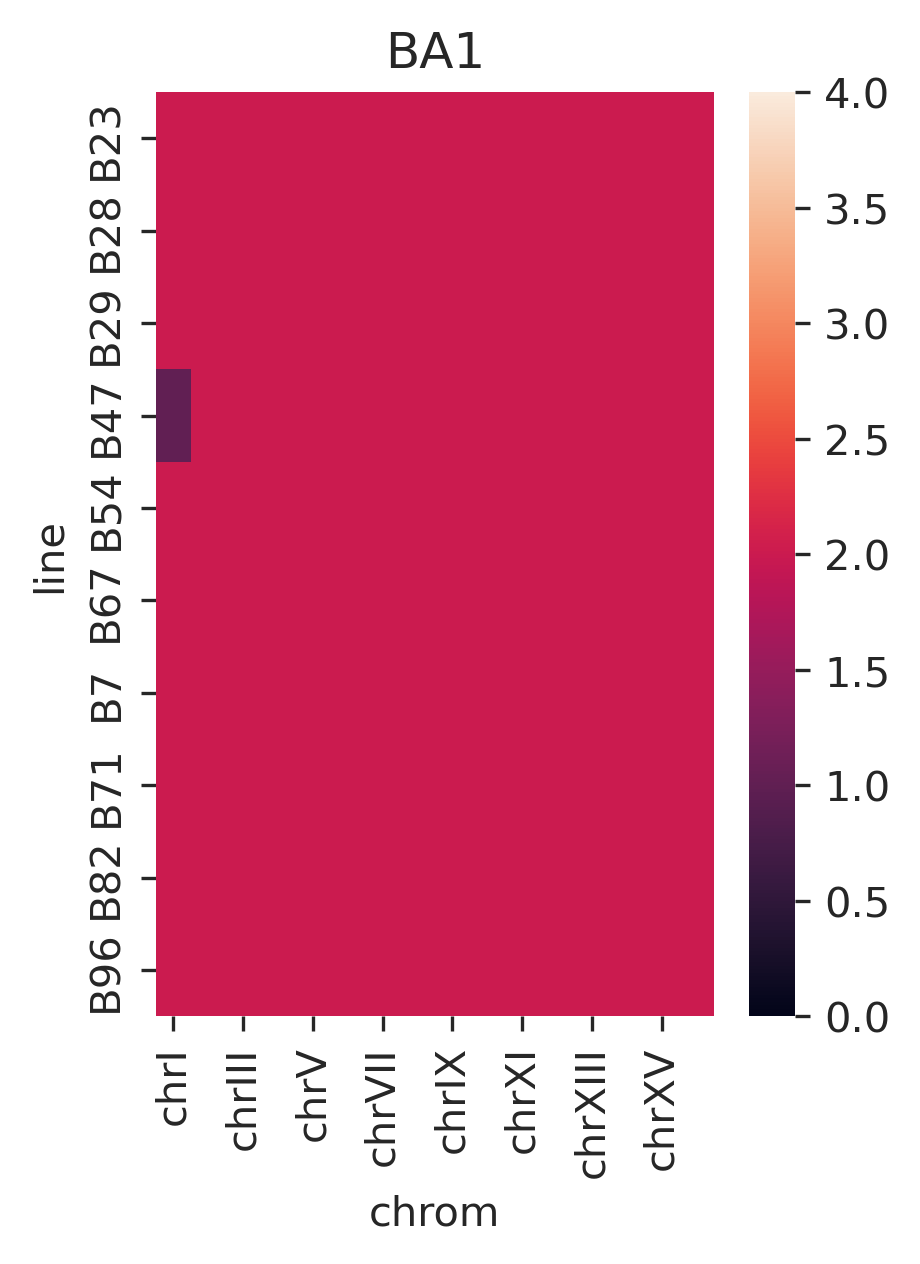

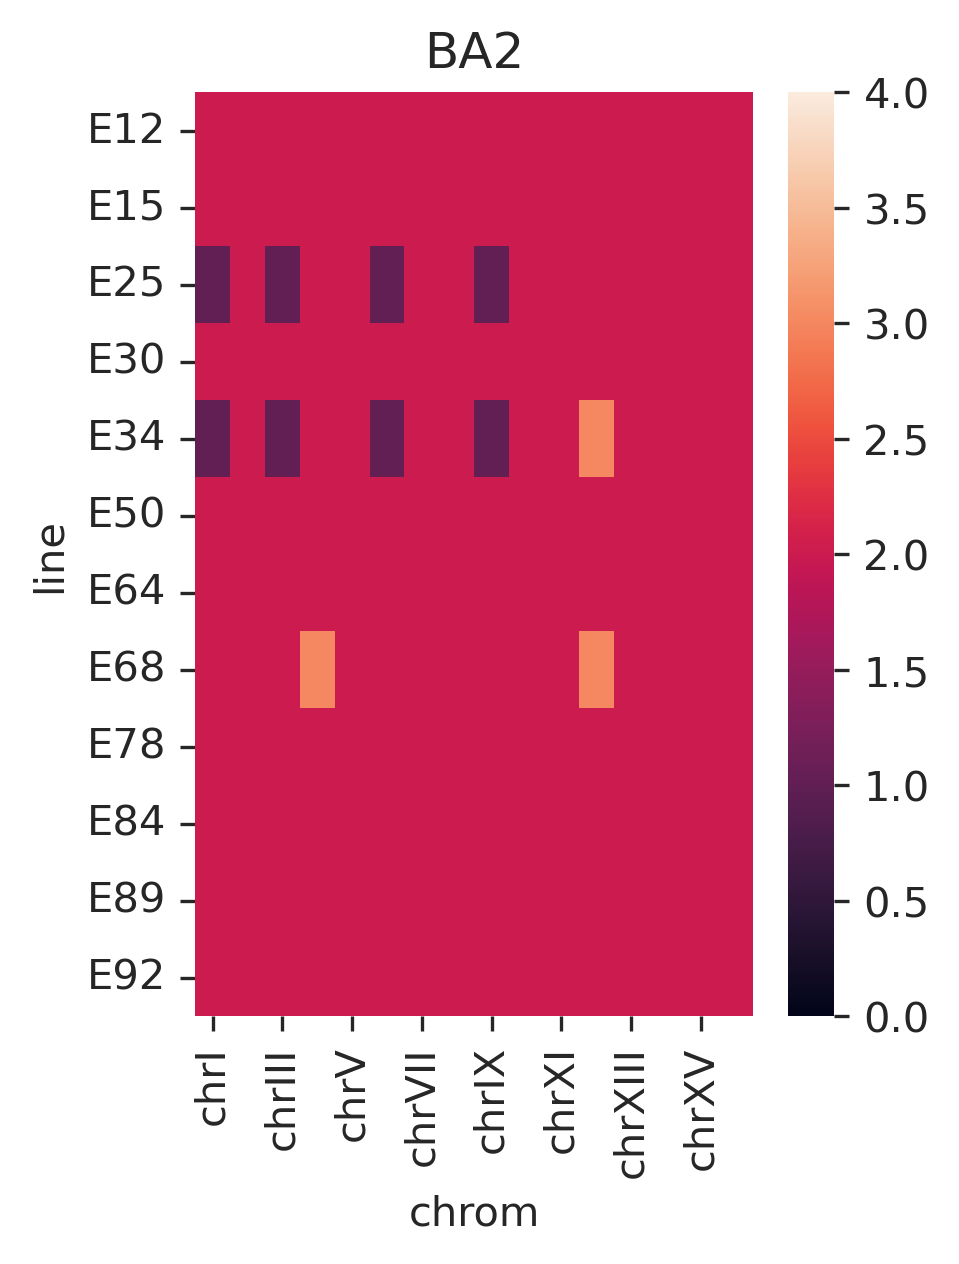

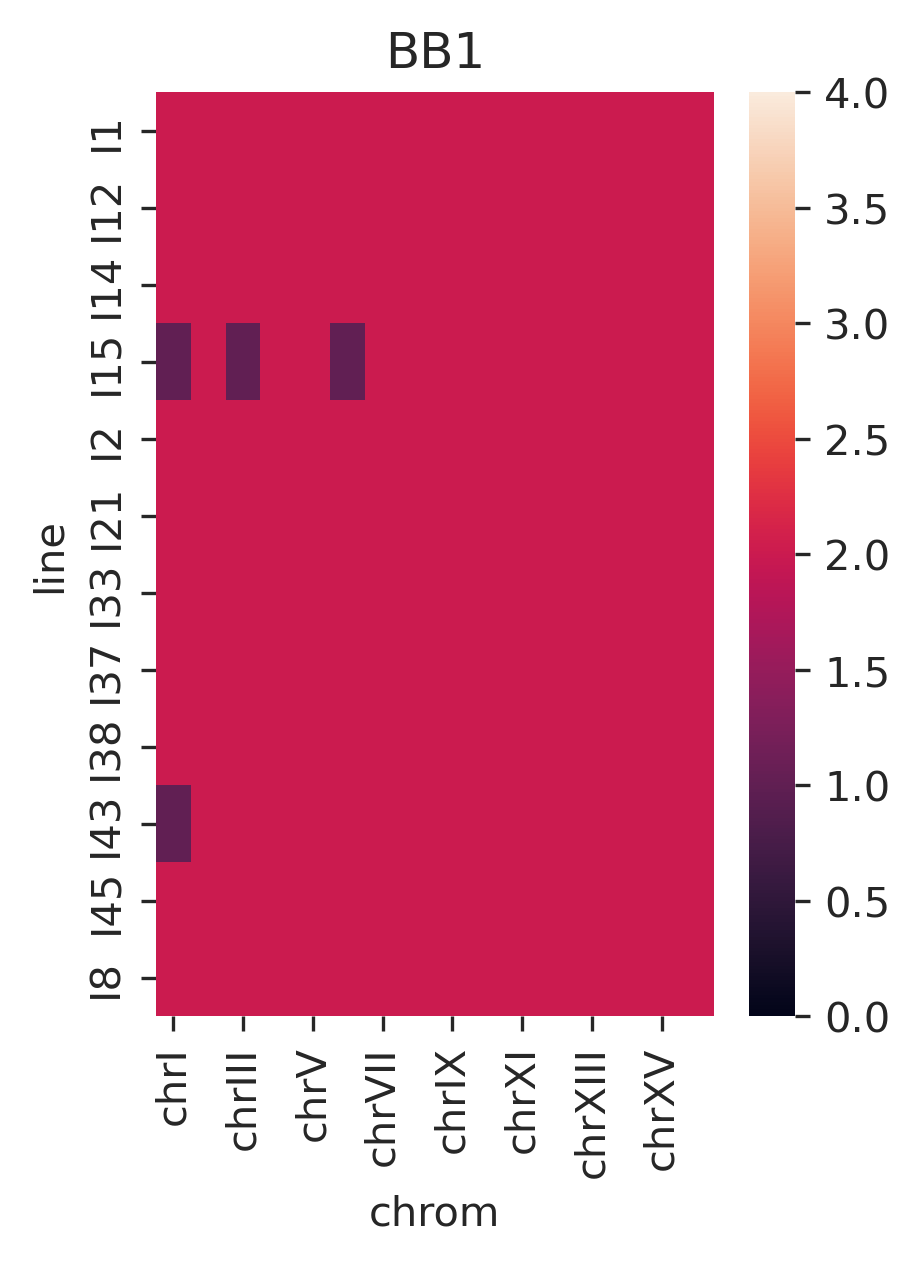

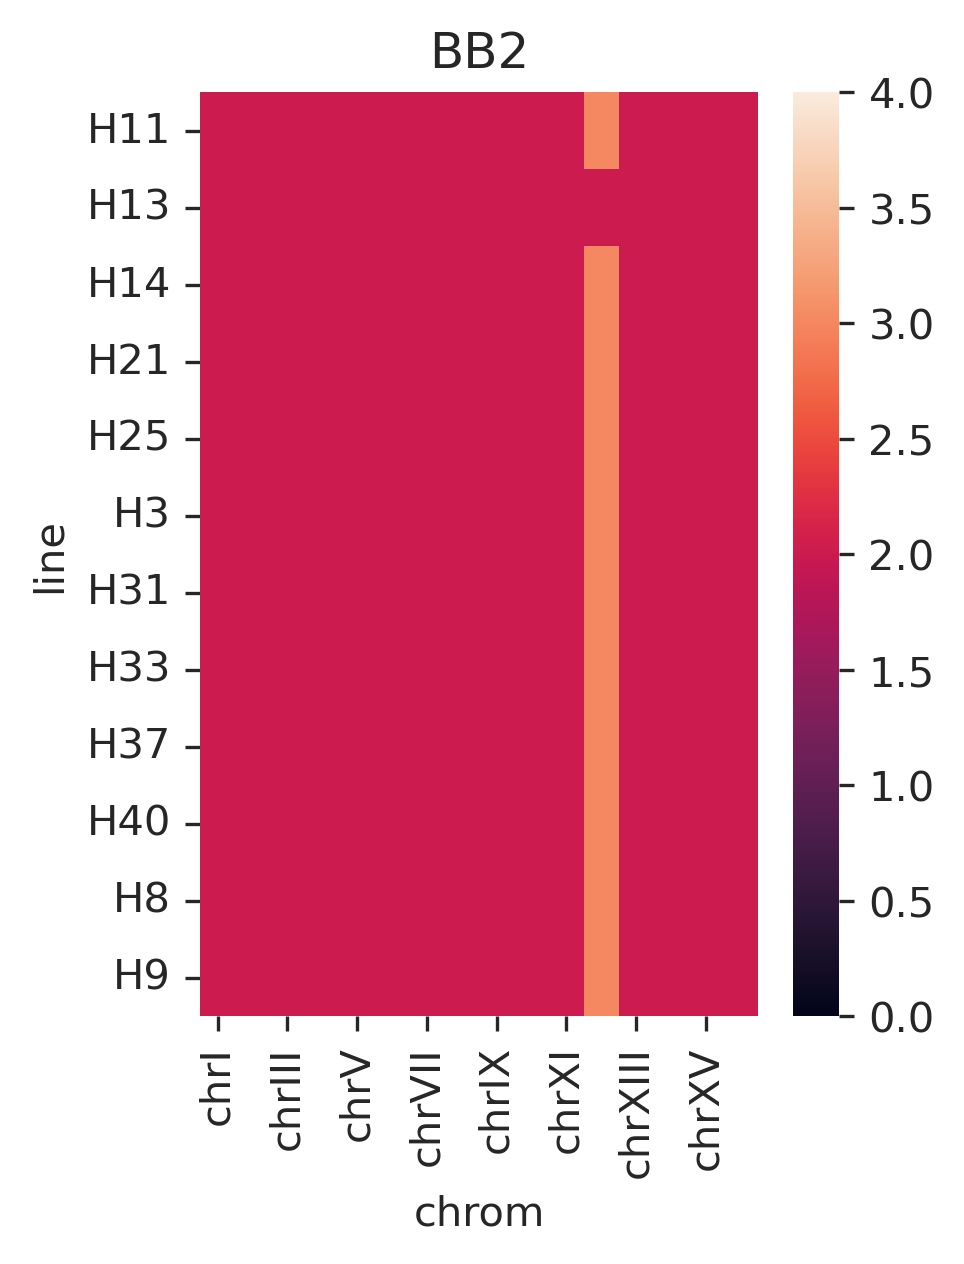

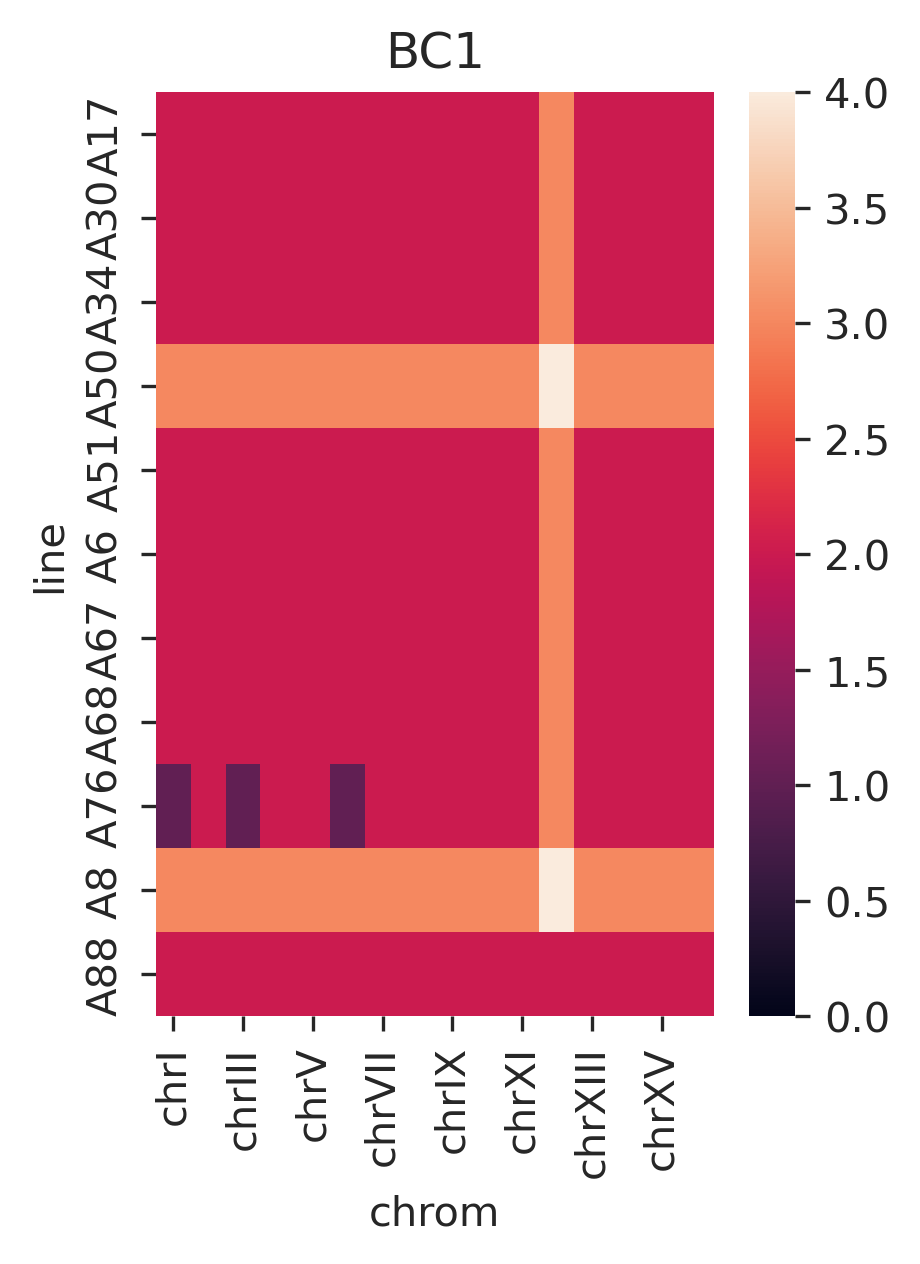

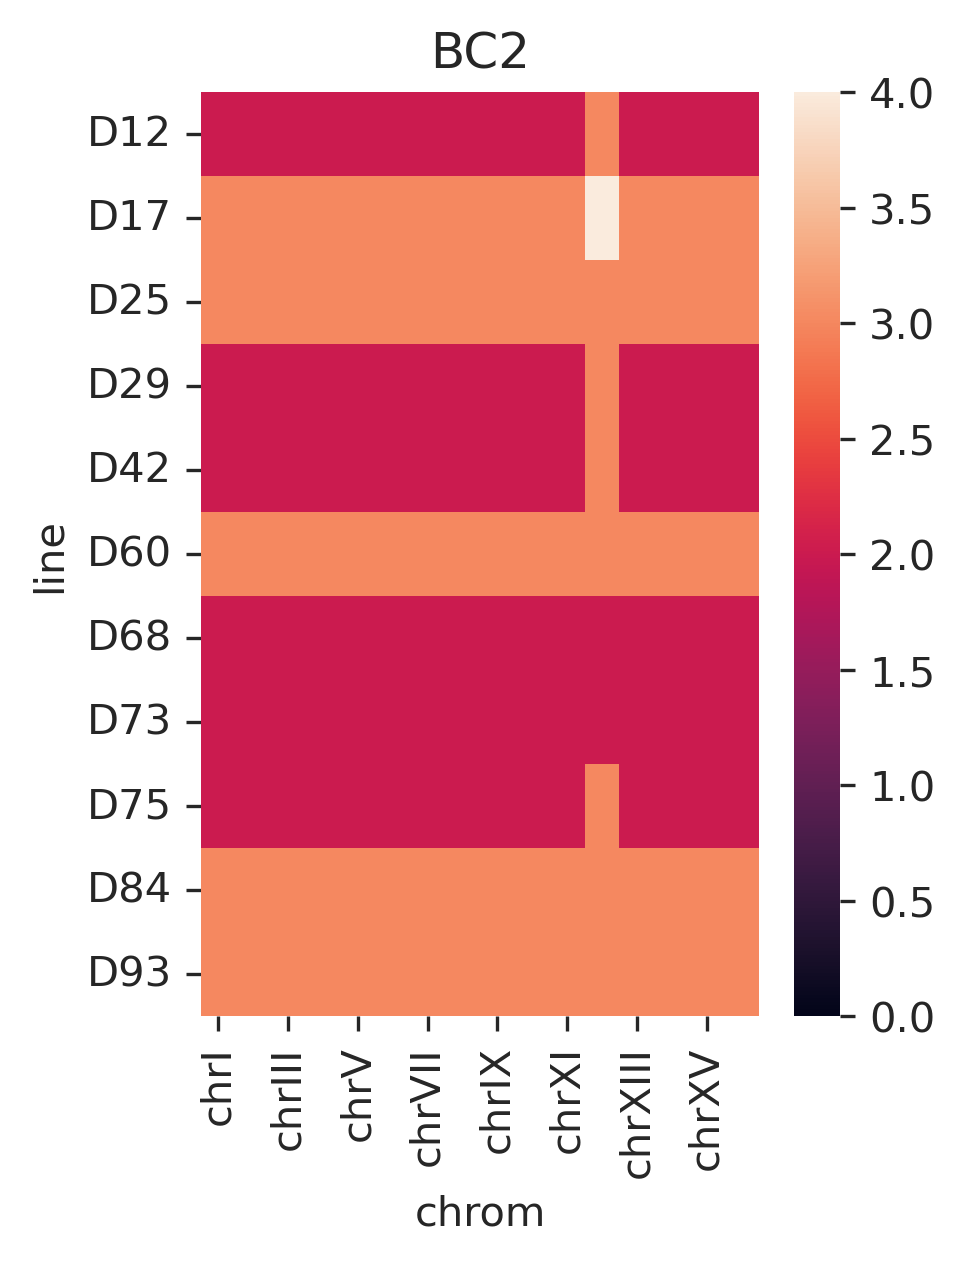

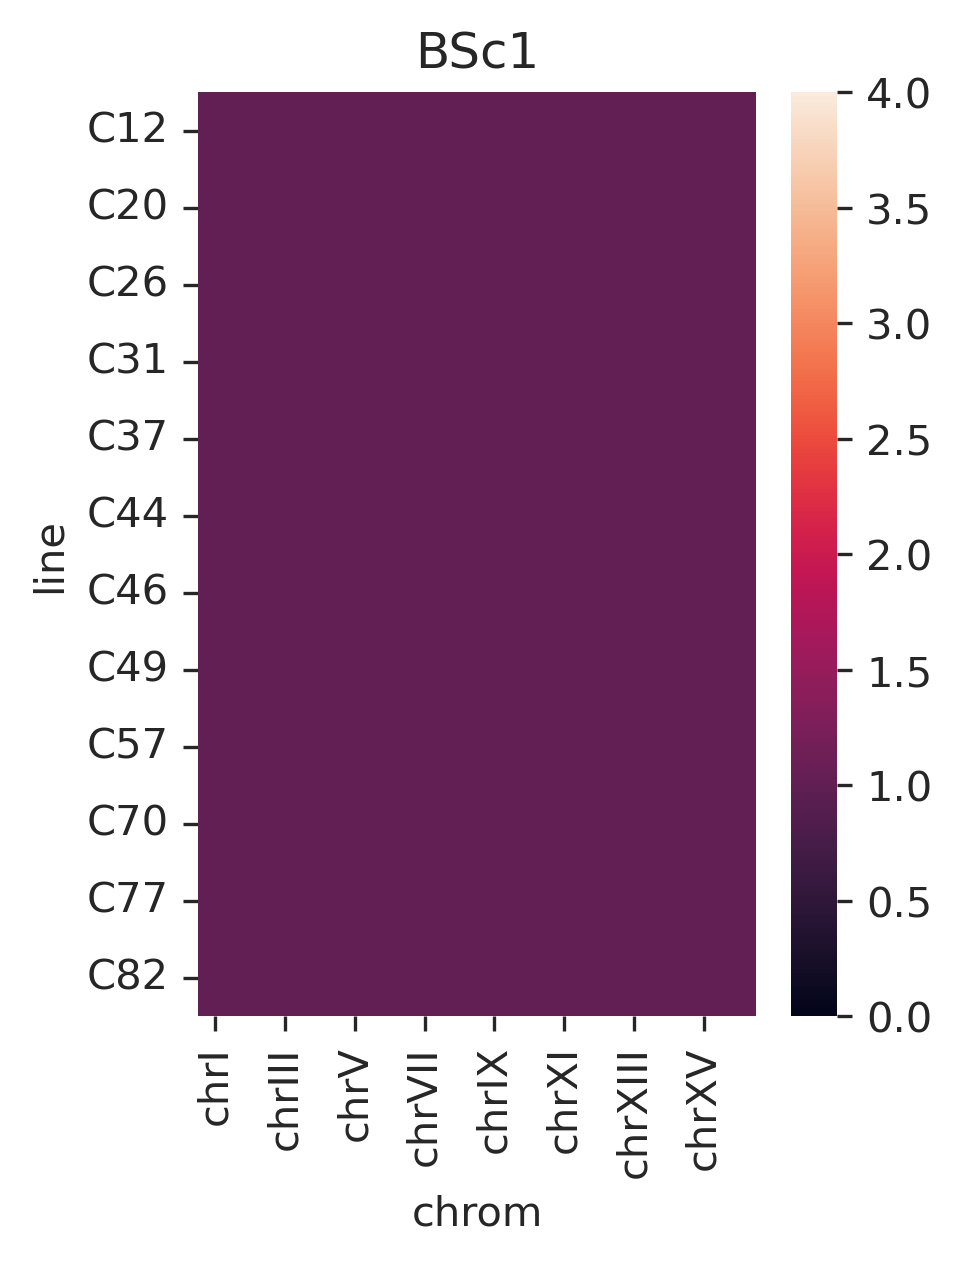

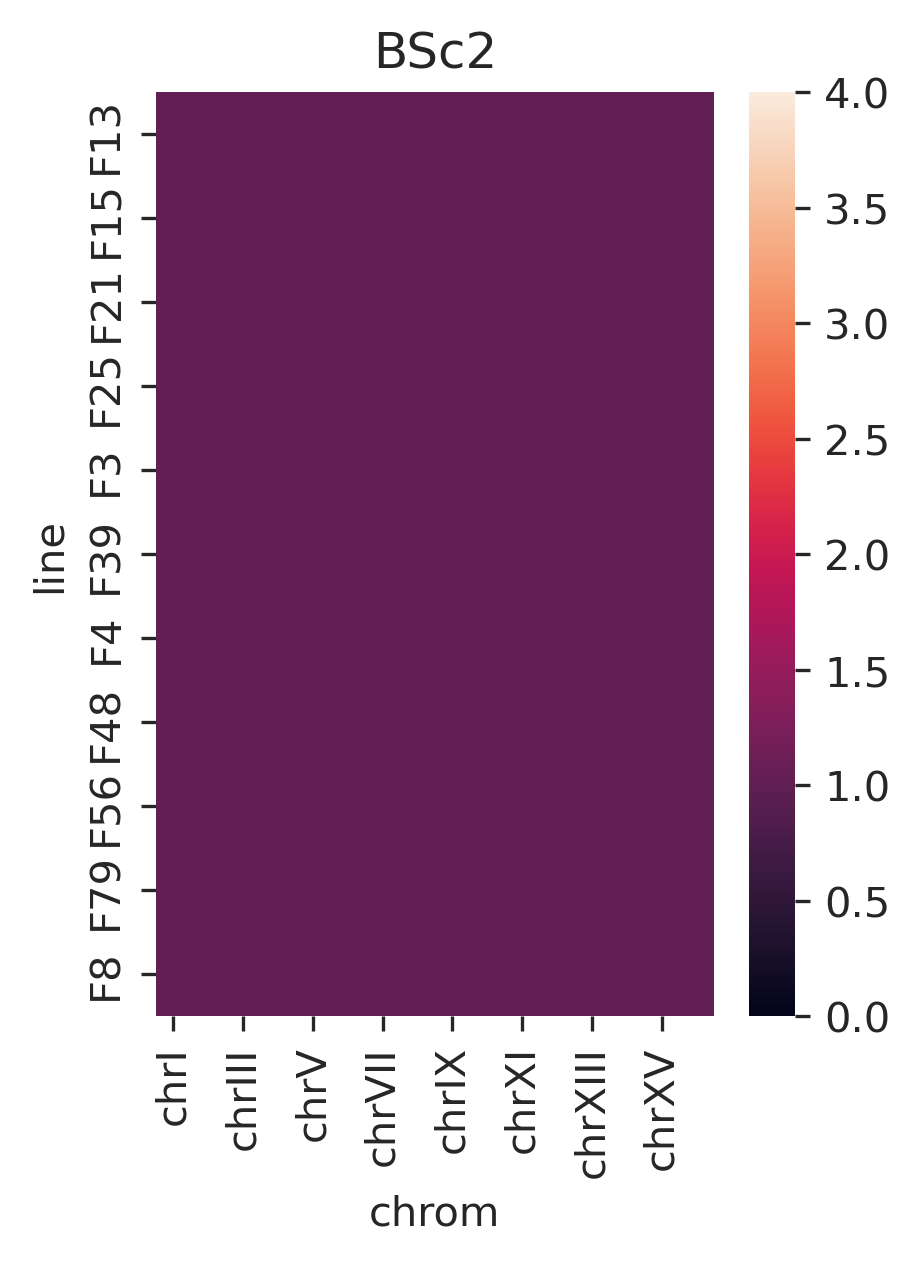

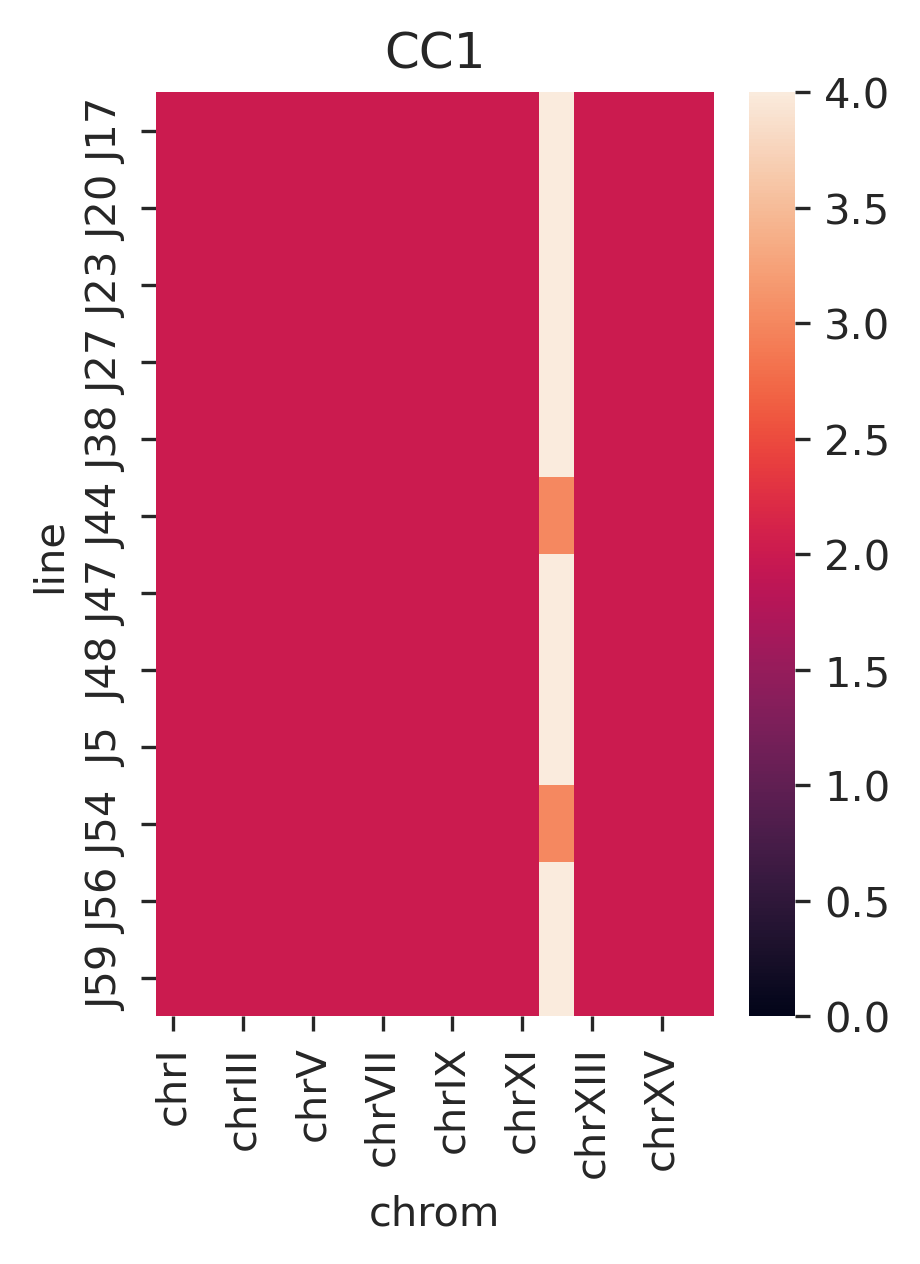

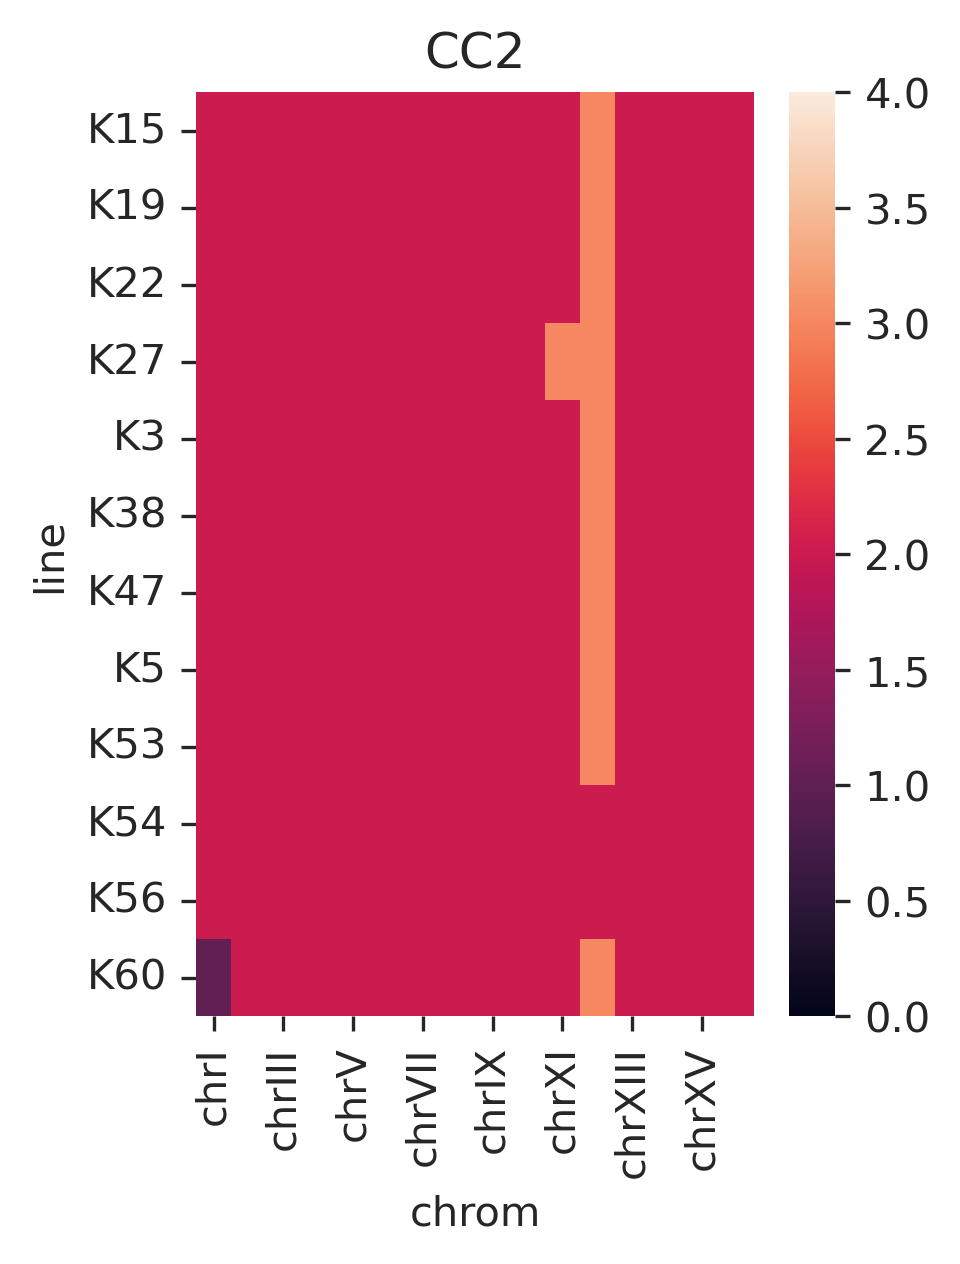

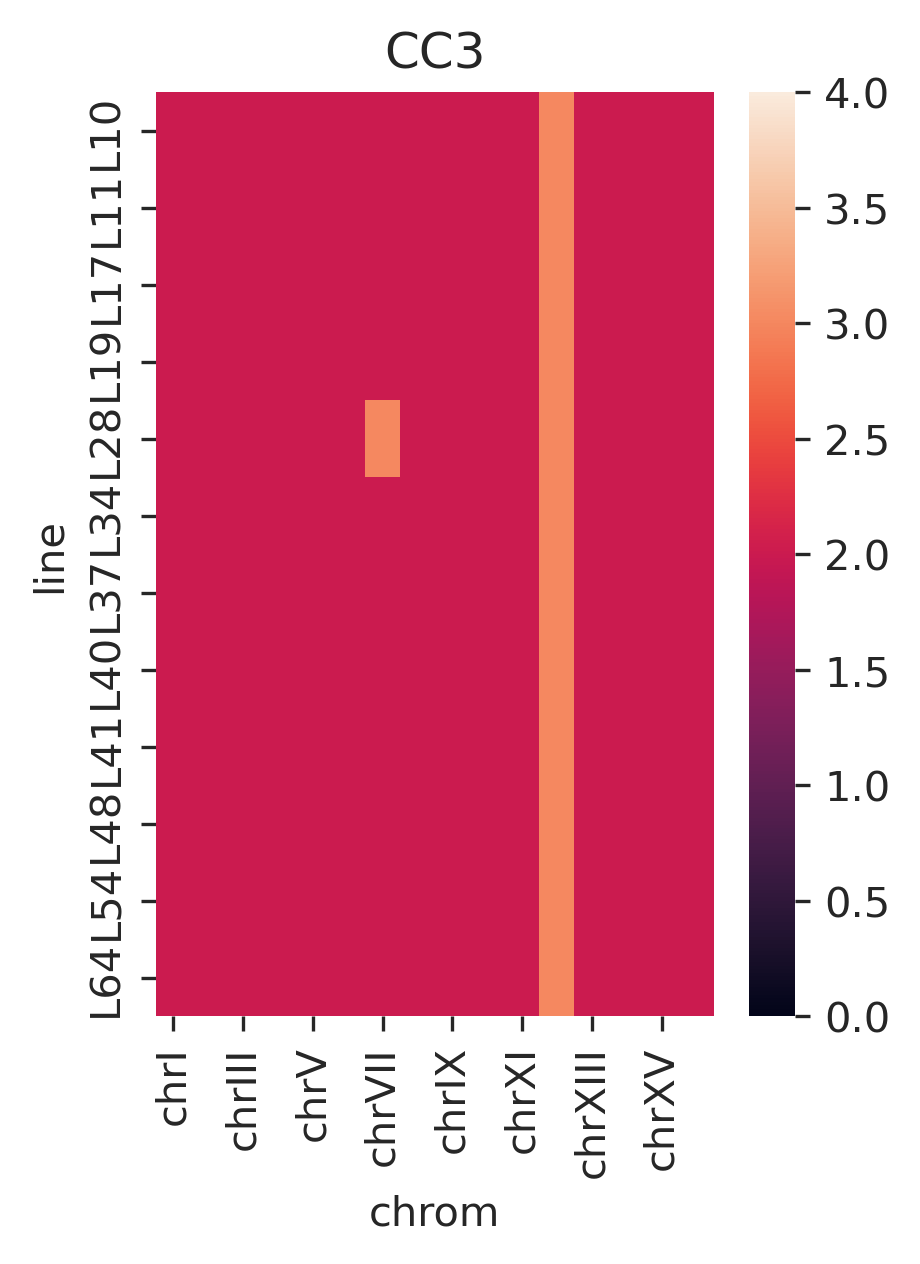

In [451]:
for cross, df in new.loc[new['timepoint']=='cn_Tini'].groupby('cross'):
    fig, ax = plt.subplots(figsize=[3,4])
    dat = df.pivot_table(index='line', columns='chrom', values='cn')
    dat = dat.loc[:, chrom_order]
    
    sns.heatmap(dat, vmin=0, vmax=4, ax=ax)
    ax.set_title(cross)
    
    plt.show()
    plt.close()

In [444]:
chrom_order = ['chrI','chrII','chrIII','chrIV','chrV','chrVI','chrVII','chrVIII',
               'chrIX','chrX','chrXI','chrXII','chrXIII','chrXIV','chrXV','chrXVI']

In [441]:
dat = new.pivot_table(index=['co','line','timepoint'], columns='chrom', values='cn')

<AxesSubplot: xlabel='chrom', ylabel='co-line-timepoint'>

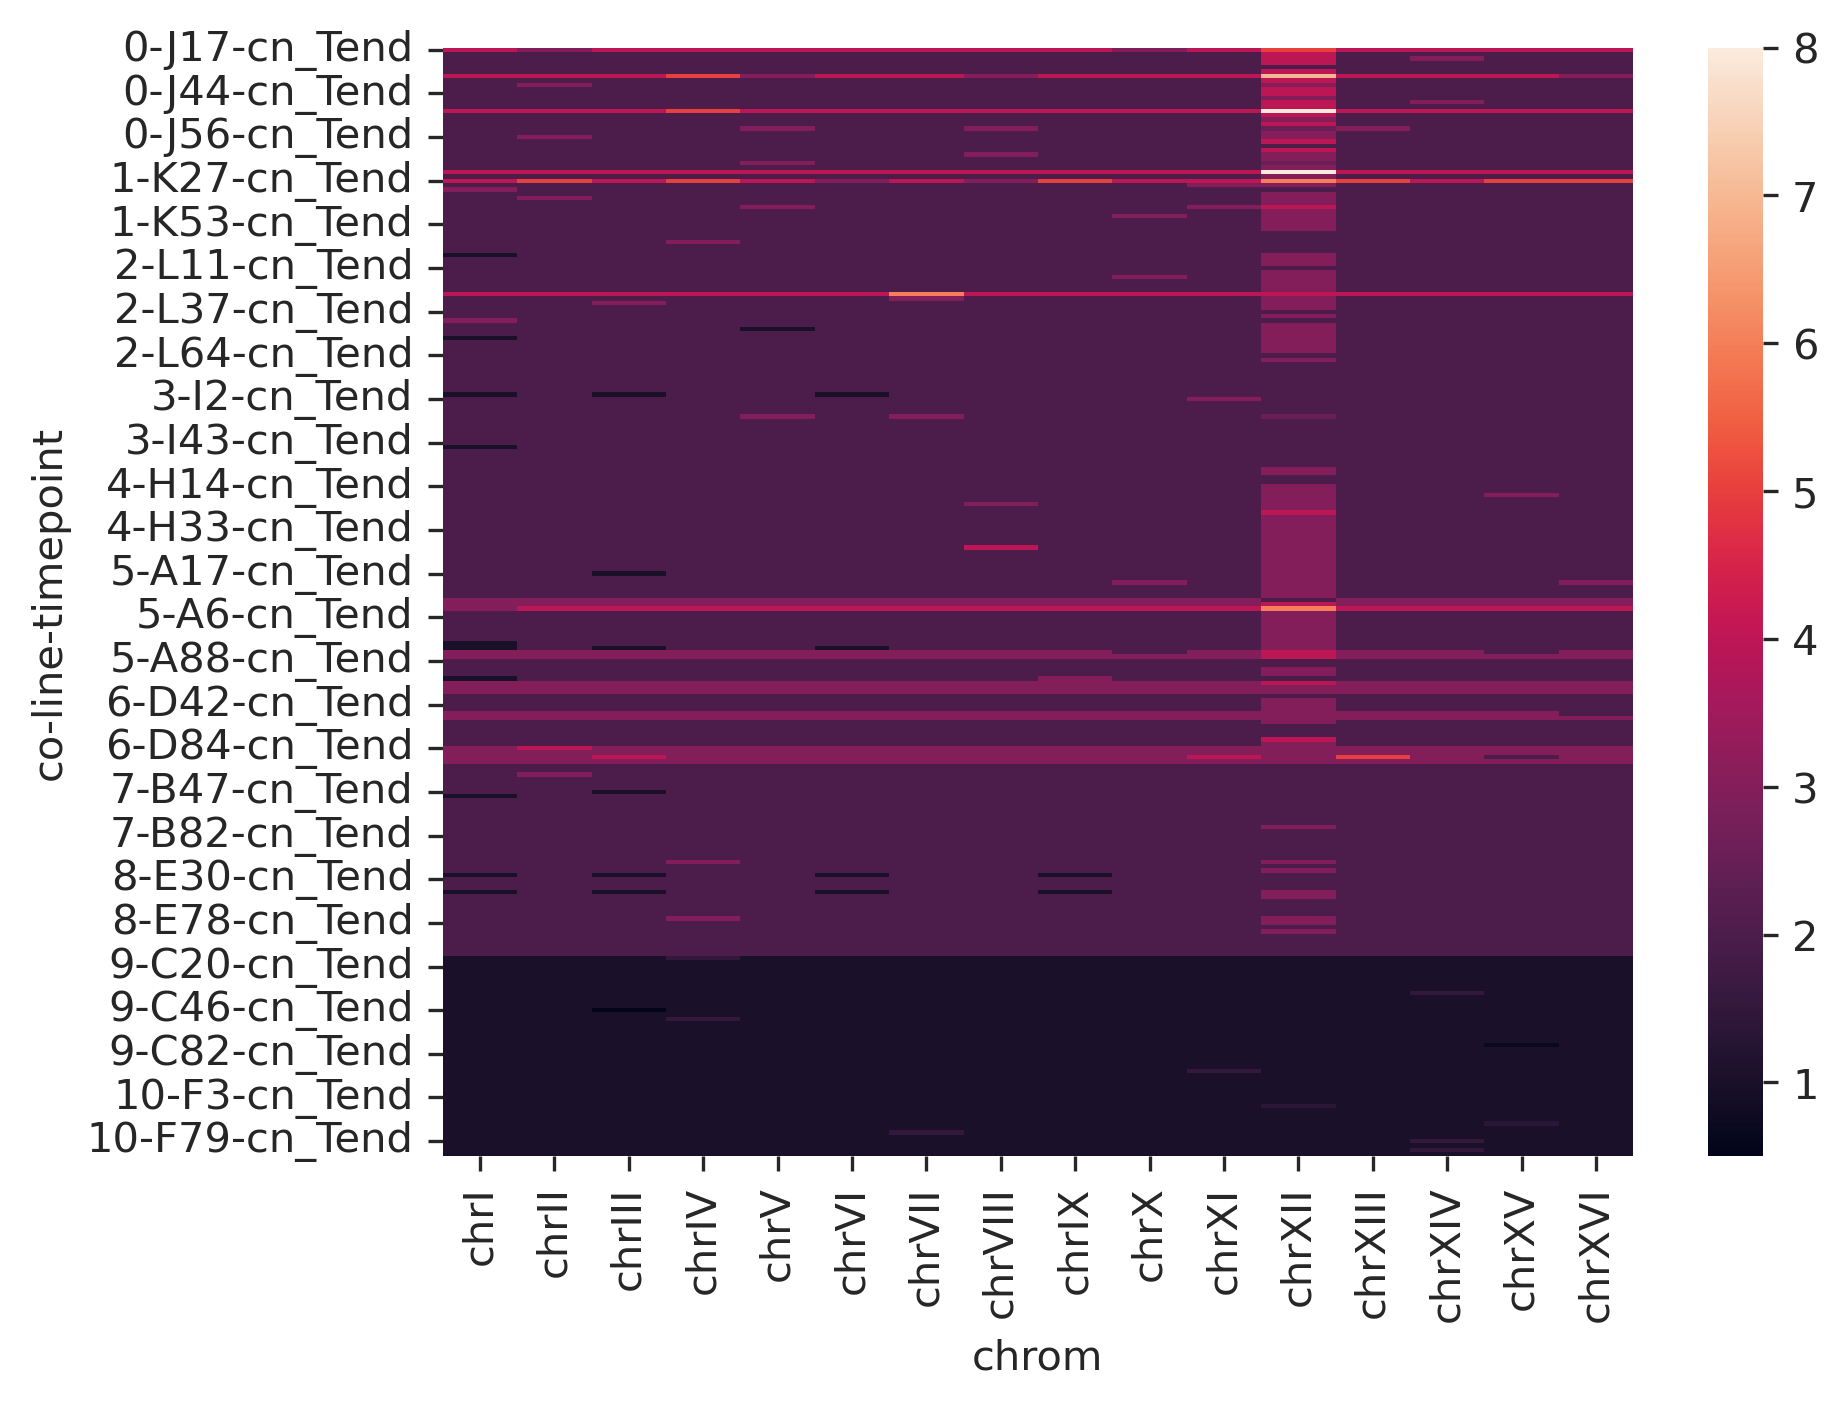

In [446]:
sns.heatmap(dat.loc[:, chrom_order])